In [23]:
import torch
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### data preprocess

In [25]:
train = pd.read_csv("snli_train.tsv", sep = '\t')

In [26]:
val = pd.read_csv("snli_val.tsv", sep = '\t')

In [6]:
PAD_IDX = 0
UNK_IDX = 1

ft_home = 'C:/Users/gong/Documents/learning/NLP/wiki-news-300d-1M.vec/'
with open(ft_home + 'wiki-news-300d-1M.vec', encoding = "utf-8") as f:
    loaded_embeddings_ft = np.zeros((999996, 300))
    words_ft = {}
    idx2words_ft = {}
    ordered_words_ft = []
    for i, line in enumerate(f):
        if(i == 0):
            continue
        s = line.split()
        loaded_embeddings_ft[(i+1), :] = np.asarray(s[1:])
        words_ft[s[0]] = i+1
        idx2words_ft[i+1] = s[0]
        ordered_words_ft.append(s[0])

In [5]:
s1 = train['sentence1'].values
s2 = train['sentence2'].values
label = train['label'].values
s1_val = val['sentence1'].values
s2_val = val['sentence2'].values
label_val = val['label'].values

In [6]:
s1 = [i.split() for i in s1]
s2 = [i.split() for i in s2]
s1_val = [i.split() for i in s1_val]
s2_val = [i.split() for i in s2_val]

In [9]:
all_words = []
for i in s1:
    all_words += i
for i in s2:
    all_words += i
max_vocab_size = 20000

def build_vocab(all_tokens):
    """
    Build vocabularys through training data and pre-trained vectors
    """
    words_counter = Counter(all_words)
    vocab, count = zip(*words_counter.most_common(max_vocab_size))
    PAD_IDX = 0 
    UNK_IDX = 1
    vocab = [i for i in list(vocab) if i in ordered_words_ft]
    vocab_size = len(vocab)
    loaded_embeddings = np.zeros((vocab_size+2, 300))
    for i in range(vocab_size):
        loaded_embeddings[(i+2), :] = loaded_embeddings_ft[words_ft[vocab[i]],]
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return  vocab_size, loaded_embeddings, token2id, id2token
num_embeddings, loaded_embeddings, token2id, id2token = build_vocab(all_words)

In [7]:
import pickle as pkl
voc_data = pkl.load(open("voc_data_2.p","rb"))
num_embeddings, loaded_embeddings, token2id, id2token = voc_data["num_embeddings"], voc_data["loaded_embeddings"], voc_data["token2id"], voc_data["id2token"]

In [8]:
PAD_IDX = 0
UNK_IDX = 1
def word_emb(x):
    """
    map the words into embedding vectors
    """
    return [token2id[i] if i in token2id else UNK_IDX for i in x]
s1 = list(map(word_emb, s1))
s2 = list(map(word_emb, s2))
s1_val = list(map(word_emb, s1_val))
s2_val = list(map(word_emb, s2_val))

In [9]:
x_train = {"s1": s1,
           "s2": s2}
x_val = {"s1": s1_val,
           "s2": s2_val}

In [10]:
def one_hot_label(x):
    """
    map the labels to be numbers
    """
    if(x == "neutral"):
        return 0
    elif(x=="entailment"):
        return 1
    else:
        return 2
label = list(map(one_hot_label, label))
label_val = list(map(one_hot_label, label_val))

In [11]:
import torch.utils.data as Data
from torch.utils.data import Dataset, DataLoader, TensorDataset
class MyDataset(Dataset):
    """
    create container for data
    """
    def __init__(self, x, y):
        assert len(x["s1"]) == len(y)
        self.length = len(y)
        self.x = x
        self.y = y
        
    def __getitem__(self, index):
        return {
        "s1": self.x["s1"][index],
        "s2": self.x["s2"][index],
        "s1_len": len(self.x["s1"][index]),
        "s2_len": len(self.x["s2"][index])
        }, self.y[index]
    
    def __len__(self):
        return self.length

In [12]:
MAX_WORD_LENGTH = 82
def vocab_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    s1_list = []
    s2_list = []
    s1_len_list = []
    s2_len_list = []
    label_list = []

    for datum in batch:
        label_list.append(datum[1])
        s1_len_list.append(min(MAX_WORD_LENGTH, datum[0]["s1_len"]))
        s2_len_list.append(min(MAX_WORD_LENGTH, datum[0]["s2_len"]))
        s1 = np.pad(np.array(datum[0]["s1"][:MAX_WORD_LENGTH]),
                                pad_width=((0,max(0, MAX_WORD_LENGTH-datum[0]["s1_len"]))),
                                mode="constant", constant_values=PAD_IDX)
        s1_list.append(s1)
        s2 = np.pad(np.array(datum[0]["s2"][:MAX_WORD_LENGTH]),
                                pad_width=((0,max(0, MAX_WORD_LENGTH-datum[0]["s2_len"]))),
                                mode="constant", constant_values=PAD_IDX)
        s2_list.append(s2)
    ind_dec_order1 = np.argsort(s1_len_list)[::-1]
    s1_list = np.array(s1_list)[ind_dec_order1]
    s1_len_list = np.array(s1_len_list)[ind_dec_order1]
    ind_dec_order2 = np.argsort(s2_len_list)[::-1]
    s2_list = np.array(s2_list)[ind_dec_order2]
    s2_len_list = np.array(s2_len_list)[ind_dec_order2]       
    x = {
        "s1": torch.from_numpy(np.array(s1_list)).long().to(device),
        "s2": torch.from_numpy(np.array(s2_list)).long().to(device),
        "s1_len": torch.LongTensor(s1_len_list).to(device),
        "s2_len": torch.LongTensor(s2_len_list).to(device),
        "s1_order": torch.from_numpy(ind_dec_order1.copy()).to(device),
        "s2_order": torch.from_numpy(ind_dec_order2.copy()).to(device)
    }
    y = torch.LongTensor(np.array(label_list)[ind_dec_order1])
    return x, y.to(device)

In [13]:
train_dataset = MyDataset(x_train, label)
val_dataset = MyDataset(x_val, label_val)

BATCH_SIZE = 64

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                batch_size=BATCH_SIZE,
                                collate_fn=vocab_collate_func,
                                shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                batch_size=BATCH_SIZE,
                                collate_fn=vocab_collate_func,
                                shuffle=False)

In [14]:
def get_n_params(model):
    """
    calculate number of paramters for each model
    """
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp - (num_embeddings - 2) * emb_size

In [15]:
def do_train(model, dataloader, criterion, optimizer):
    """
    use model to train the dataset in the dataloader
    """
    model.train()
    train_loss = 0
    for data, labels in dataloader:
        optimizer.zero_grad()
        y_hat = model(data)
        loss = criterion(y_hat, labels.long())
        loss.backward()
        model.embed.weight.grad[2:,:] = torch.zeros(model.embed.weight.grad[2:,:].size()).to(device)
        optimizer.step()
        train_loss += loss.item() * len(data) / len(dataloader.dataset)
    return train_loss

def do_eval(model, dataloader):
    """
    use model to evaluate the dataset in the dataloader
    """
    model.eval()
    y_ls = []
    y_hat_ls = []
    val_loss = 0
    with torch.no_grad():
        for data, labels in dataloader:
            y_hat = model(data)
            loss = criterion(y_hat, labels.long())
            y_hat_ls.append(y_hat)
            y_ls.append(labels)
            val_loss += loss.item() * len(data) / len(dataloader.dataset)
    optimizer.zero_grad()
    return val_loss, torch.cat(y_hat_ls, dim=0), torch.cat(y_ls, dim=0)

def acc(model, dataloader):
    """
    calculate the model accuracy on the dataset in the dataloader
    """
    val_loss, pred,true = do_eval(
    model = model,
    dataloader = dataloader,
    )
    return val_loss, (torch.exp(pred).max(1)[1] == true).float().mean().item()

## RNN
### baseline model

In [15]:

class RNN(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, middle_size, num_embeddings):
        # RNN Accepts the following hyperparams:
        # emb_size: Embedding Size
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes
        #
        super(RNN, self).__init__()
        
        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embed = nn.Embedding(num_embeddings, emb_size, padding_idx=PAD_IDX)
        self.rnn = nn.GRU(emb_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        #self.rnn2 = nn.GRU(emb_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        
        self.linear1 = nn.Linear(4*hidden_size, middle_size)
        self.linear2 = nn.Linear(middle_size, 3)
        
        self.init_weights()
  
    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden = torch.randn(self.num_layers*2, batch_size, self.hidden_size).float()

        return hidden
    
    def init_weights(self):
        loaded_embeddings[:2, :] = np.random.randn(2,300)
        self.embed.weight = nn.Parameter(torch.from_numpy(loaded_embeddings).float())
        return

    def forward(self, x):
        # reset hidden state
        out1 = self.embed(x['s1'])
        out2 = self.embed(x['s2'])
        batch_size, seq_len = x['s1'].size()
        self.hidden1 = self.init_hidden(batch_size).to(device)
        self.hidden2 = self.init_hidden(batch_size).to(device)
        out1 = torch.nn.utils.rnn.pack_padded_sequence(out1, x['s1_len'], batch_first=True)
        out2 = torch.nn.utils.rnn.pack_padded_sequence(out2, x['s2_len'], batch_first=True)
        _, self.hidden1 = self.rnn(out1, self.hidden1)
        _, self.hidden2 = self.rnn(out2, self.hidden2)
        final_hidden1 = self.hidden1.view(1, 2, batch_size, self.hidden_size).transpose(1,2).contiguous().view(batch_size, -1)
        final_hidden2 = self.hidden2.view(1, 2, batch_size, self.hidden_size).transpose(1,2).contiguous().view(batch_size, -1)
        tmp = torch.zeros(final_hidden2.size()).to(device)
        for i in range(batch_size):
            tmp[x['s2_order'][i],:] = final_hidden2[i]
        final_hidden2 = tmp[list(x['s1_order']),:]
        out = torch.cat([final_hidden1,final_hidden2], dim=1)
        out = self.linear1(out)
        #out = torch.sigmoid(out)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.log_softmax(out, dim=1)
        return out

### hidden size

In [22]:
learning_rate = 0.001
emb_size = 300
num_layers = 1
middle_size = 200
num_epochs = 15
hidden_size = 100


loss_train_t = []
loss_val_t = []
acc_val_t = []
acc_train_t = []

for hidden_size in [100, 300, 500, 700]:
    print("hidden size = {}".format(hidden_size))
    loss_train = []
    loss_val = []
    acc_val = []
    acc_train = []

    model = RNN(emb_size, hidden_size, num_layers, middle_size, num_embeddings).to(device)
    criterion = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    print("Number of parameters is {}".format(get_n_params(model)))
    
    for epoch in range(num_epochs):
    #scheduler.step()
        loss = do_train(
            model=model, 
            criterion=criterion,
            dataloader=train_loader,
            optimizer=optimizer,
        )
        val_loss, val_acc = acc(model, val_loader)
        train_loss, train_acc = acc(model,train_loader)
        loss_val.append(val_loss)
        acc_val.append(val_acc)
        loss_train.append(train_loss)
        acc_train.append(train_acc)
        print('Epoch: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format( 
                           epoch+1, num_epochs, train_loss, val_loss, val_acc))
    loss_train_t.append(loss_train)
    loss_val_t.append(loss_val)
    acc_val_t.append(acc_val)
    acc_train_t.append(acc_train)

hidden size = 100
Number of parameters is 323203
Epoch: [1/15], Train Loss: 0.0739765442419053, Val Loss: 0.08010913968086243, Val Acc: 0.625
Epoch: [2/15], Train Loss: 0.06670845749974243, Val Loss: 0.07416755855083466, Val Acc: 0.6610000133514404
Epoch: [3/15], Train Loss: 0.06150600370287891, Val Loss: 0.0699022343158722, Val Acc: 0.6820000410079956
Epoch: [4/15], Train Loss: 0.05723324069023133, Val Loss: 0.0686785683631897, Val Acc: 0.6910000443458557
Epoch: [5/15], Train Loss: 0.05318951747059819, Val Loss: 0.06678662395477294, Val Acc: 0.7080000042915344
Epoch: [6/15], Train Loss: 0.04990676172852509, Val Loss: 0.07049342930316926, Val Acc: 0.6920000314712524
Epoch: [7/15], Train Loss: 0.045165269157886406, Val Loss: 0.06741165697574614, Val Acc: 0.7070000171661377
Epoch: [8/15], Train Loss: 0.041683591235876165, Val Loss: 0.0666582909822464, Val Acc: 0.7230000495910645
Epoch: [9/15], Train Loss: 0.03750262838244442, Val Loss: 0.07362760233879088, Val Acc: 0.7090000510215759
Epo

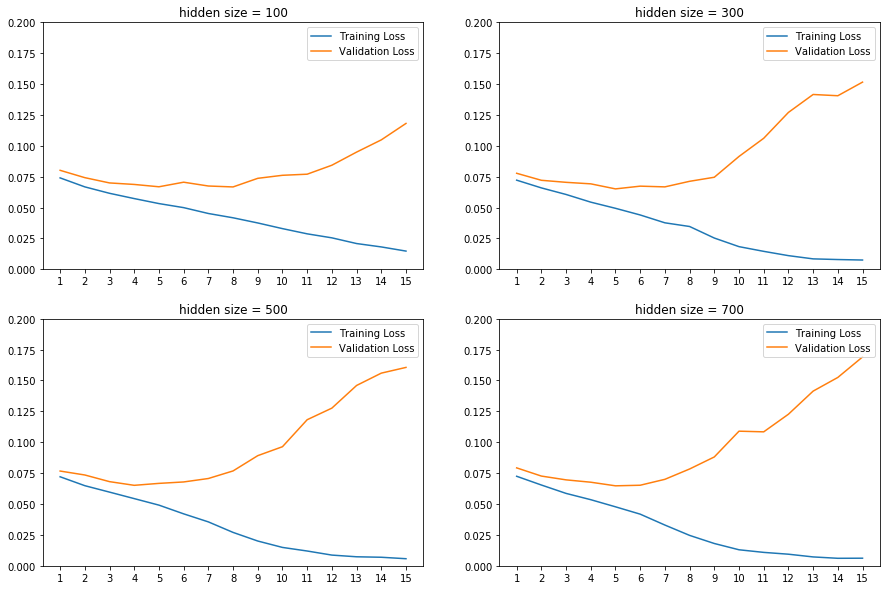

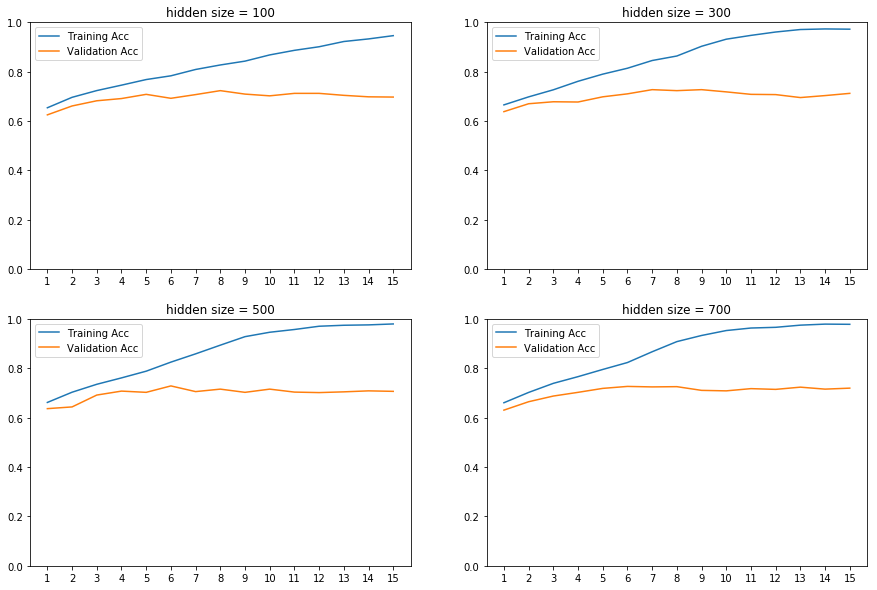

In [20]:
plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.plot(range(1, len(loss_train_t[0])+1), loss_train_t[0], label="Training Loss")
plt.plot(range(1, len(loss_val_t[0])+1), loss_val_t[0], label="Validation Loss")
plt.xticks(range(1, len(loss_val_t[0])+1))
plt.ylim(0, 0.2)
plt.legend()
plt.title("hidden size = 100")

plt.subplot(222)
plt.plot(range(1, len(loss_train_t[1])+1), loss_train_t[1], label="Training Loss")
plt.plot(range(1, len(loss_val_t[1])+1), loss_val_t[1], label="Validation Loss")
plt.xticks(range(1, len(loss_val_t[1])+1))
plt.ylim(0, 0.2)
plt.legend()
plt.title("hidden size = 300")

plt.subplot(223)
plt.plot(range(1, len(loss_train_t[2])+1), loss_train_t[2], label="Training Loss")
plt.plot(range(1, len(loss_val_t[2])+1), loss_val_t[2], label="Validation Loss")
plt.xticks(range(1, len(loss_val_t[2])+1))
plt.ylim(0, 0.2)
plt.legend()
plt.title("hidden size = 500")

plt.subplot(224)
plt.plot(range(1, len(loss_train_t[3])+1), loss_train_t[3], label="Training Loss")
plt.plot(range(1, len(loss_val_t[3])+1), loss_val_t[3], label="Validation Loss")
plt.xticks(range(1, len(loss_val_t[3])+1))
plt.ylim(0, 0.2)
plt.legend()
plt.title("hidden size = 700")
plt.savefig("hidden_rnn_loss.pdf")
plt.show()

plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.plot(range(1, len(acc_train_t[0])+1), acc_train_t[0], label="Training Acc")
plt.plot(range(1, len(acc_val_t[0])+1), acc_val_t[0], label="Validation Acc")
plt.xticks(range(1, len(acc_val_t[0])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("hidden size = 100")

plt.subplot(222)
plt.plot(range(1, len(acc_train_t[1])+1), acc_train_t[1], label="Training Acc")
plt.plot(range(1, len(acc_val_t[1])+1), acc_val_t[1], label="Validation Acc")
plt.xticks(range(1, len(acc_val_t[1])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("hidden size = 300")

plt.subplot(223)
plt.plot(range(1, len(acc_train_t[2])+1), acc_train_t[2], label="Training Acc")
plt.plot(range(1, len(acc_val_t[2])+1), acc_val_t[2], label="Validation Acc")
plt.xticks(range(1, len(acc_val_t[2])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("hidden size = 500")

plt.subplot(224)
plt.plot(range(1, len(acc_train_t[3])+1), acc_train_t[3], label="Training Acc")
plt.plot(range(1, len(acc_val_t[3])+1), acc_val_t[3], label="Validation Acc")
plt.xticks(range(1, len(acc_val_t[3])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("hidden size = 700")
plt.savefig("hidden_rnn_acc.pdf")
plt.show()

In [29]:
loss_train_t = pkl.load(open("loss_train_t.p","rb"))
loss_val_t = pkl.load(open("loss_val_t.p","rb"))
acc_train_t = pkl.load(open("acc_train_t.p","rb"))
acc_val_t = pkl.load(open("acc_val_t.p","rb"))

### ways of interacting

In [30]:
class RNN_max(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, middle_size, num_embeddings):
        # RNN Accepts the following hyperparams:
        # emb_size: Embedding Size
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes
        #
        super(RNN_max, self).__init__()
        
        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embed = nn.Embedding(num_embeddings, emb_size, padding_idx=PAD_IDX)
        self.rnn = nn.GRU(emb_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        #self.rnn2 = nn.GRU(emb_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        
        self.linear1 = nn.Linear(2*hidden_size, middle_size)
        self.linear2 = nn.Linear(middle_size, 3)
        
        self.init_weights()
  
    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden = torch.randn(self.num_layers*2, batch_size, self.hidden_size).float()

        return hidden
    
    def init_weights(self):
        loaded_embeddings[:2, :] = np.random.randn(2,300)
        self.embed.weight = nn.Parameter(torch.from_numpy(loaded_embeddings).float())
        return

    def forward(self, x):
        # reset hidden state
        out1 = self.embed(x['s1'])
        out2 = self.embed(x['s2'])
        batch_size, seq_len = x['s1'].size()
        self.hidden1 = self.init_hidden(batch_size).to(device)
        self.hidden2 = self.init_hidden(batch_size).to(device)
        out1 = torch.nn.utils.rnn.pack_padded_sequence(out1, x['s1_len'], batch_first=True)
        out2 = torch.nn.utils.rnn.pack_padded_sequence(out2, x['s2_len'], batch_first=True)
        _, self.hidden1 = self.rnn(out1, self.hidden1)
        _, self.hidden2 = self.rnn(out2, self.hidden2)
        final_hidden1 = self.hidden1.view(1, 2, batch_size, self.hidden_size).transpose(1,2).contiguous().view(batch_size, -1)
        final_hidden2 = self.hidden2.view(1, 2, batch_size, self.hidden_size).transpose(1,2).contiguous().view(batch_size, -1)
        tmp = torch.zeros(final_hidden2.size()).to(device)
        for i in range(batch_size):
            tmp[x['s2_order'][i],:] = final_hidden2[i]
        final_hidden2 = tmp[list(x['s1_order']),:]
        out = torch.max(final_hidden1,final_hidden2)
        out = self.linear1(out)
        #out = torch.sigmoid(out)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.log_softmax(out, dim=1)
        return out

learning_rate = 0.001
emb_size = 300
middle_size = 200
num_epochs =15
hidden_size = 500
num_layers = 1

loss_train_t = [loss_train_t[2]]
loss_val_t = [loss_val_t[2]]
acc_val_t = [acc_val_t[2]]
acc_train_t = [acc_train_t[2]]


print("maxpooling")

loss_train = []
loss_val = []
acc_val = []
acc_train = []


model = RNN_max(emb_size, hidden_size, num_layers, middle_size, num_embeddings).to(device)
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print("Number of parameters is {}".format(get_n_params(model)))
for epoch in range(num_epochs):
#scheduler.step()
    loss = do_train(
        model=model, 
        criterion=criterion,
        dataloader=train_loader,
        optimizer=optimizer,
    )
    val_loss, val_acc = acc(model, val_loader)
    train_loss, train_acc = acc(model,train_loader)
    loss_val.append(val_loss)
    acc_val.append(val_acc)
    loss_train.append(train_loss)
    acc_train.append(train_acc)
    print('Epoch: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format( 
                           epoch+1, num_epochs, train_loss, val_loss, val_acc))
        
loss_train_t.append(loss_train)
loss_val_t.append(loss_val)
acc_val_t.append(acc_val)
acc_train_t.append(acc_train)

maxpooling
Number of parameters is 2608003
Epoch: [1/15], Train Loss: 0.0720800836122036, Val Loss: 0.07754312324523926, Val Acc: 0.6540000438690186
Epoch: [2/15], Train Loss: 0.060598986411094694, Val Loss: 0.06675567770004272, Val Acc: 0.7000000476837158
Epoch: [3/15], Train Loss: 0.05331482843935497, Val Loss: 0.062393040418624875, Val Acc: 0.7250000238418579
Epoch: [4/15], Train Loss: 0.04565433319240808, Val Loss: 0.06247283148765563, Val Acc: 0.7270000576972961
Epoch: [5/15], Train Loss: 0.03882522889584301, Val Loss: 0.0632393581867218, Val Acc: 0.7270000576972961
Epoch: [6/15], Train Loss: 0.031255871218442886, Val Loss: 0.06451406371593475, Val Acc: 0.7290000319480896
Epoch: [7/15], Train Loss: 0.023172331286072677, Val Loss: 0.0669284770488739, Val Acc: 0.7310000061988831
Epoch: [8/15], Train Loss: 0.0166766164060682, Val Loss: 0.0806490125656128, Val Acc: 0.7270000576972961
Epoch: [9/15], Train Loss: 0.012247888916507362, Val Loss: 0.08671827149391174, Val Acc: 0.72700005769

In [31]:
class RNN_pair_mul(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, middle_size, num_embeddings):
        # RNN Accepts the following hyperparams:
        # emb_size: Embedding Size
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes
        #
        super(RNN_pair_mul, self).__init__()
        
        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embed = nn.Embedding(num_embeddings, emb_size, padding_idx=PAD_IDX)
        self.rnn = nn.GRU(emb_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        #self.rnn2 = nn.GRU(emb_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        
        self.linear1 = nn.Linear(2*hidden_size, middle_size)
        self.linear2 = nn.Linear(middle_size, 3)
        
        self.init_weights()
  
    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden = torch.randn(self.num_layers*2, batch_size, self.hidden_size).float()

        return hidden
    
    def init_weights(self):
        loaded_embeddings[:2, :] = np.random.randn(2,300)
        self.embed.weight = nn.Parameter(torch.from_numpy(loaded_embeddings).float())
        return

    def forward(self, x):
        # reset hidden state
        out1 = self.embed(x['s1'])
        out2 = self.embed(x['s2'])
        batch_size, seq_len = x['s1'].size()
        self.hidden1 = self.init_hidden(batch_size).to(device)
        self.hidden2 = self.init_hidden(batch_size).to(device)
        out1 = torch.nn.utils.rnn.pack_padded_sequence(out1, x['s1_len'], batch_first=True)
        out2 = torch.nn.utils.rnn.pack_padded_sequence(out2, x['s2_len'], batch_first=True)
        _, self.hidden1 = self.rnn(out1, self.hidden1)
        _, self.hidden2 = self.rnn(out2, self.hidden2)
        final_hidden1 = self.hidden1.view(1, 2, batch_size, self.hidden_size).transpose(1,2).contiguous().view(batch_size, -1)
        final_hidden2 = self.hidden2.view(1, 2, batch_size, self.hidden_size).transpose(1,2).contiguous().view(batch_size, -1)
        tmp = torch.zeros(final_hidden2.size()).to(device)
        for i in range(batch_size):
            tmp[x['s2_order'][i],:] = final_hidden2[i]
        final_hidden2 = tmp[list(x['s1_order']),:]
        out = torch.max(final_hidden1,final_hidden2)
        out = self.linear1(out)
        #out = torch.sigmoid(out)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.log_softmax(out, dim=1)
        return out

learning_rate = 0.001
emb_size = 300
middle_size = 200
num_epochs =15
hidden_size = 500


print("pairwise multiplication")

loss_train = []
loss_val = []
acc_val = []
acc_train = []


model = RNN_pair_mul(emb_size, hidden_size, num_layers, middle_size, num_embeddings).to(device)
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print("Number of parameters is {}".format(get_n_params(model)))
for epoch in range(num_epochs):
#scheduler.step()
    loss = do_train(
        model=model, 
        criterion=criterion,
        dataloader=train_loader,
        optimizer=optimizer,
    )
    val_loss, val_acc = acc(model, val_loader)
    train_loss, train_acc = acc(model,train_loader)
    loss_val.append(val_loss)
    acc_val.append(val_acc)
    loss_train.append(train_loss)
    acc_train.append(train_acc)
    print('Epoch: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format( 
                           epoch+1, num_epochs, train_loss, val_loss, val_acc))
        
loss_train_t.append(loss_train)
loss_val_t.append(loss_val)
acc_val_t.append(acc_val)
acc_train_t.append(acc_train)

pairwise multiplication
Number of parameters is 2608003
Epoch: [1/15], Train Loss: 0.07271218661427481, Val Loss: 0.07855353355407715, Val Acc: 0.6420000195503235
Epoch: [2/15], Train Loss: 0.06283357438802722, Val Loss: 0.06983281588554384, Val Acc: 0.6860000491142273
Epoch: [3/15], Train Loss: 0.052687072920799126, Val Loss: 0.06413388097286224, Val Acc: 0.7080000042915344
Epoch: [4/15], Train Loss: 0.04673302441656588, Val Loss: 0.06345355832576752, Val Acc: 0.7210000157356262
Epoch: [5/15], Train Loss: 0.04169943040788174, Val Loss: 0.06860688185691834, Val Acc: 0.7000000476837158
Epoch: [6/15], Train Loss: 0.03227247947841884, Val Loss: 0.06571865701675415, Val Acc: 0.7300000190734863
Epoch: [7/15], Train Loss: 0.02500383332982659, Val Loss: 0.07058786129951476, Val Acc: 0.7310000061988831
Epoch: [8/15], Train Loss: 0.018057620898038196, Val Loss: 0.08466744303703308, Val Acc: 0.7200000286102295
Epoch: [9/15], Train Loss: 0.016748156552463783, Val Loss: 0.09526485693454743, Val Ac

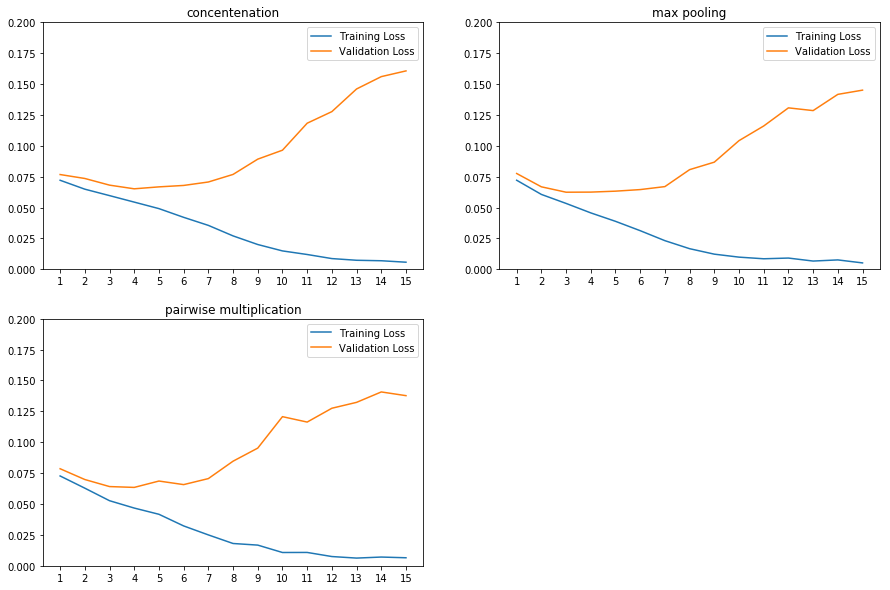

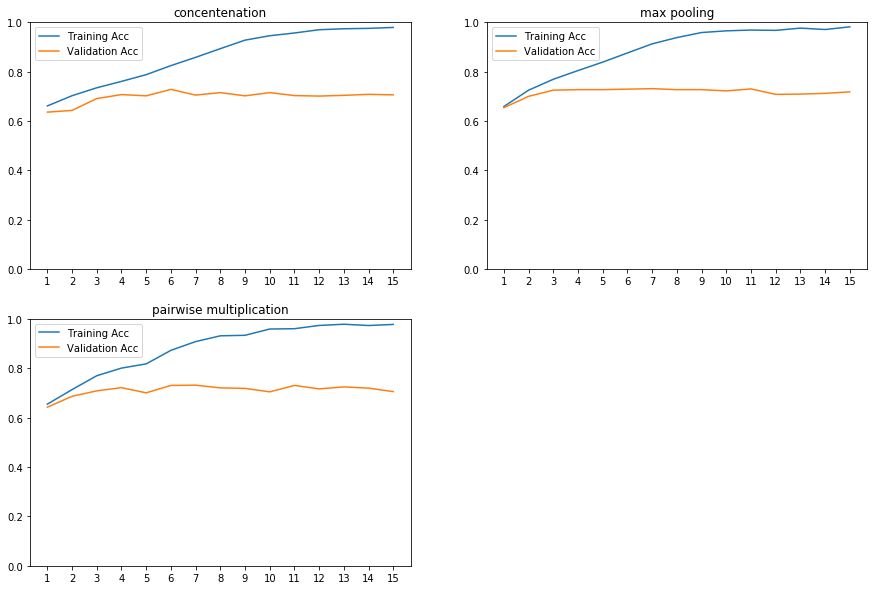

In [32]:
plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.plot(range(1, len(loss_train_t[0])+1), loss_train_t[0], label="Training Loss")
plt.plot(range(1, len(loss_val_t[0])+1), loss_val_t[0], label="Validation Loss")
plt.xticks(range(1, len(loss_val_t[0])+1))
plt.ylim(0, 0.2)
plt.legend()
plt.title("concentenation")

plt.subplot(222)
plt.plot(range(1, len(loss_train_t[1])+1), loss_train_t[1], label="Training Loss")
plt.plot(range(1, len(loss_val_t[1])+1), loss_val_t[1], label="Validation Loss")
plt.xticks(range(1, len(loss_val_t[1])+1))
plt.ylim(0, 0.2)
plt.legend()
plt.title("max pooling")

plt.subplot(223)
plt.plot(range(1, len(loss_train_t[2])+1), loss_train_t[2], label="Training Loss")
plt.plot(range(1, len(loss_val_t[2])+1), loss_val_t[2], label="Validation Loss")
plt.xticks(range(1, len(loss_val_t[2])+1))
plt.ylim(0, 0.2)
plt.legend()
plt.title("pairwise multiplication")

plt.savefig("interacting_rnn_loss.pdf")
plt.show()

plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.plot(range(1, len(acc_train_t[0])+1), acc_train_t[0], label="Training Acc")
plt.plot(range(1, len(acc_val_t[0])+1), acc_val_t[0], label="Validation Acc")
plt.xticks(range(1, len(acc_val_t[0])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("concentenation")

plt.subplot(222)
plt.plot(range(1, len(acc_train_t[1])+1), acc_train_t[1], label="Training Acc")
plt.plot(range(1, len(acc_val_t[1])+1), acc_val_t[1], label="Validation Acc")
plt.xticks(range(1, len(acc_val_t[1])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("max pooling")

plt.subplot(223)
plt.plot(range(1, len(acc_train_t[2])+1), acc_train_t[2], label="Training Acc")
plt.plot(range(1, len(acc_val_t[2])+1), acc_val_t[2], label="Validation Acc")
plt.xticks(range(1, len(acc_val_t[2])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("pairwise multiplication")

plt.savefig("interacting_acc_rnn.pdf")
plt.show()

In [33]:
pkl.dump(loss_train_t,open("loss_train_t.p","wb"))
pkl.dump(loss_val_t,open("loss_val_t.p","wb"))
pkl.dump(acc_train_t,open("acc_train_t.p","wb"))
pkl.dump(acc_val_t,open("acc_val_t.p","wb"))

### Regularization

In [34]:
learning_rate = 0.001
emb_size = 300
middle_size = 200
num_epochs =15
hidden_size = 500

loss_train_t = [loss_train_t[1]]
loss_val_t = [loss_val_t[1]]
acc_val_t = [acc_val_t[1]]
acc_train_t = [acc_train_t[1]]


print("weight decay")

loss_train = []
loss_val = []
acc_val = []
acc_train = []


model = RNN_max(emb_size, hidden_size, num_layers, middle_size, num_embeddings).to(device)
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
print("Number of parameters is {}".format(get_n_params(model)))
for epoch in range(num_epochs):
#scheduler.step()
    loss = do_train(
        model=model, 
        criterion=criterion,
        dataloader=train_loader,
        optimizer=optimizer,
    )
    val_loss, val_acc = acc(model, val_loader)
    train_loss, train_acc = acc(model,train_loader)
    loss_val.append(val_loss)
    acc_val.append(val_acc)
    loss_train.append(train_loss)
    acc_train.append(train_acc)
    print('Epoch: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format( 
                           epoch+1, num_epochs, train_loss, val_loss, val_acc))
        
loss_train_t.append(loss_train)
loss_val_t.append(loss_val)
acc_val_t.append(acc_val)
acc_train_t.append(acc_train)

weight decay
Number of parameters is 2608003
Epoch: [1/15], Train Loss: 0.08066584135651592, Val Loss: 0.08434397077560425, Val Acc: 0.5940000414848328
Epoch: [2/15], Train Loss: 0.07443496584177012, Val Loss: 0.0800153921842575, Val Acc: 0.6360000371932983
Epoch: [3/15], Train Loss: 0.0796577024638653, Val Loss: 0.085204665184021, Val Acc: 0.5910000205039978
Epoch: [4/15], Train Loss: 0.0846116402578353, Val Loss: 0.09027892971038817, Val Acc: 0.5270000100135803
Epoch: [5/15], Train Loss: 0.09142830688834203, Val Loss: 0.09535297071933746, Val Acc: 0.5370000004768372
Epoch: [6/15], Train Loss: 0.09699625672101966, Val Loss: 0.10079083800315856, Val Acc: 0.45000001788139343
Epoch: [7/15], Train Loss: 0.10084765256881707, Val Loss: 0.10475328469276428, Val Acc: 0.4020000100135803
Epoch: [8/15], Train Loss: 0.10125313390374206, Val Loss: 0.10478428673744201, Val Acc: 0.3850000202655792
Epoch: [9/15], Train Loss: 0.10113065382957452, Val Loss: 0.10439073300361632, Val Acc: 0.3970000147819

In [36]:
class RNN_dropout(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, middle_size, num_embeddings):
        # RNN Accepts the following hyperparams:
        # emb_size: Embedding Size
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes
        #
        super(RNN_dropout, self).__init__()
        
        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embed = nn.Embedding(num_embeddings, emb_size, padding_idx=PAD_IDX)
        self.rnn = nn.GRU(emb_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        #self.rnn2 = nn.GRU(emb_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        
        self.linear1 = nn.Linear(2*hidden_size, middle_size)
        self.linear2 = nn.Linear(middle_size, 3)
        self.dropout = nn.Dropout(p=0.5)
        
        self.init_weights()
  
    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden = torch.randn(self.num_layers*2, batch_size, self.hidden_size).float()

        return hidden
    
    def init_weights(self):
        loaded_embeddings[:2, :] = np.random.randn(2,300)
        self.embed.weight = nn.Parameter(torch.from_numpy(loaded_embeddings).float())
        return

    def forward(self, x):
        # reset hidden state
        out1 = self.embed(x['s1'])
        out2 = self.embed(x['s2'])
        batch_size, seq_len = x['s1'].size()
        self.hidden1 = self.init_hidden(batch_size).to(device)
        self.hidden2 = self.init_hidden(batch_size).to(device)
        out1 = torch.nn.utils.rnn.pack_padded_sequence(out1, x['s1_len'], batch_first=True)
        out2 = torch.nn.utils.rnn.pack_padded_sequence(out2, x['s2_len'], batch_first=True)
        _, self.hidden1 = self.rnn(out1, self.hidden1)
        _, self.hidden2 = self.rnn(out2, self.hidden2)
        final_hidden1 = self.hidden1.view(1, 2, batch_size, self.hidden_size).transpose(1,2).contiguous().view(batch_size, -1)
        final_hidden2 = self.hidden2.view(1, 2, batch_size, self.hidden_size).transpose(1,2).contiguous().view(batch_size, -1)
        tmp = torch.zeros(final_hidden2.size()).to(device)
        for i in range(batch_size):
            tmp[x['s2_order'][i],:] = final_hidden2[i]
        final_hidden2 = tmp[list(x['s1_order']),:]
        out = torch.max(final_hidden1,final_hidden2)
        out = self.linear1(out)
        #out = torch.sigmoid(out)
        out = F.relu(out)
        out = self.dropout(out)
        out = self.linear2(out)
        out = F.log_softmax(out, dim=1)
        return out


learning_rate = 0.001
emb_size = 300
middle_size = 200
num_epochs =15
hidden_size = 500


print("dropout")

loss_train = []
loss_val = []
acc_val = []
acc_train = []


model = RNN_dropout(emb_size, hidden_size, num_layers, middle_size, num_embeddings).to(device)
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print("Number of parameters is {}".format(get_n_params(model)))
for epoch in range(num_epochs):
#scheduler.step()
    loss = do_train(
        model=model, 
        criterion=criterion,
        dataloader=train_loader,
        optimizer=optimizer,
    )
    val_loss, val_acc = acc(model, val_loader)
    train_loss, train_acc = acc(model,train_loader)
    loss_val.append(val_loss)
    acc_val.append(val_acc)
    loss_train.append(train_loss)
    acc_train.append(train_acc)
    print('Epoch: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format( 
                           epoch+1, num_epochs, train_loss, val_loss, val_acc))
        
loss_train_t.append(loss_train)
loss_val_t.append(loss_val)
acc_val_t.append(acc_val)
acc_train_t.append(acc_train)

dropout
Number of parameters is 2608003
Epoch: [1/15], Train Loss: 0.07331849879980093, Val Loss: 0.07957710456848142, Val Acc: 0.6370000243186951
Epoch: [2/15], Train Loss: 0.06260139921426772, Val Loss: 0.07138554739952087, Val Acc: 0.6690000295639038
Epoch: [3/15], Train Loss: 0.05628172734797005, Val Loss: 0.06765337800979614, Val Acc: 0.690000057220459
Epoch: [4/15], Train Loss: 0.051248332352042174, Val Loss: 0.06488163113594055, Val Acc: 0.7110000252723694
Epoch: [5/15], Train Loss: 0.0447505118715764, Val Loss: 0.06774860787391664, Val Acc: 0.7020000219345093
Epoch: [6/15], Train Loss: 0.03820171908974645, Val Loss: 0.06277956408262253, Val Acc: 0.7300000190734863
Epoch: [7/15], Train Loss: 0.0299814805519581, Val Loss: 0.06840265417099, Val Acc: 0.7330000400543213
Epoch: [8/15], Train Loss: 0.02437732004687185, Val Loss: 0.07481005096435546, Val Acc: 0.7420000433921814
Epoch: [9/15], Train Loss: 0.020601052723377963, Val Loss: 0.07814461183547974, Val Acc: 0.7240000367164612
E

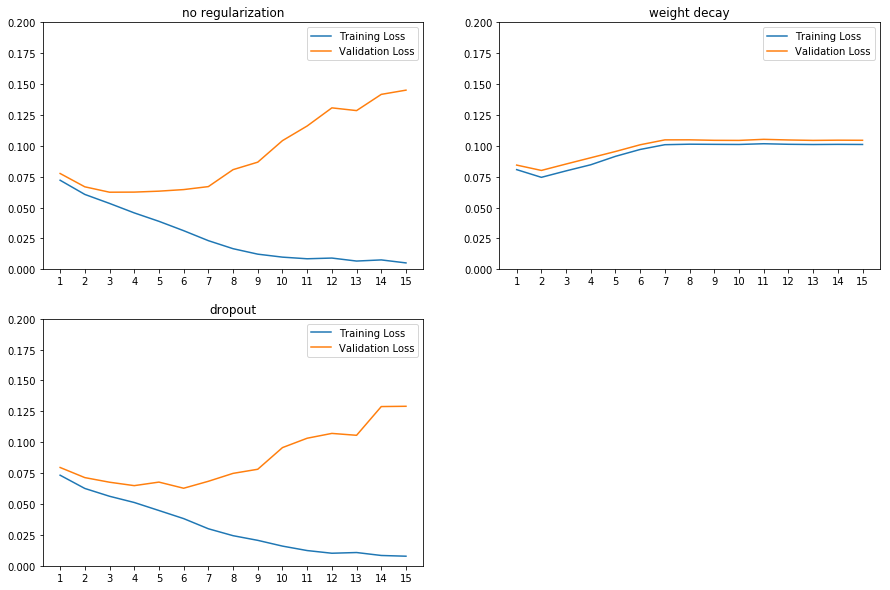

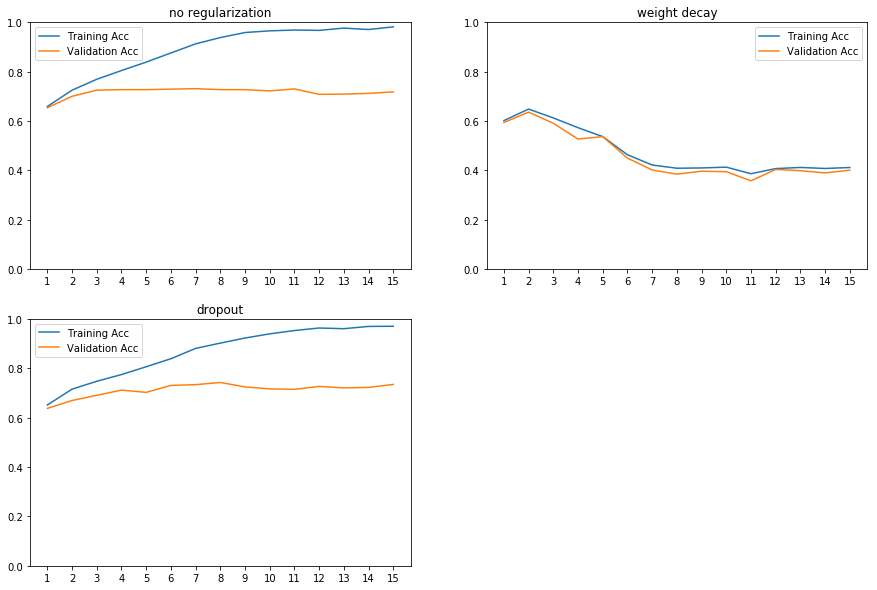

In [37]:
plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.plot(range(1, len(loss_train_t[0])+1), loss_train_t[0], label="Training Loss")
plt.plot(range(1, len(loss_val_t[0])+1), loss_val_t[0], label="Validation Loss")
plt.xticks(range(1, len(loss_val_t[0])+1))
plt.ylim(0, 0.2)
plt.legend()
plt.title("no regularization")

plt.subplot(222)
plt.plot(range(1, len(loss_train_t[1])+1), loss_train_t[1], label="Training Loss")
plt.plot(range(1, len(loss_val_t[1])+1), loss_val_t[1], label="Validation Loss")
plt.xticks(range(1, len(loss_val_t[1])+1))
plt.ylim(0, 0.2)
plt.legend()
plt.title("weight decay")

plt.subplot(223)
plt.plot(range(1, len(loss_train_t[2])+1), loss_train_t[2], label="Training Loss")
plt.plot(range(1, len(loss_val_t[2])+1), loss_val_t[2], label="Validation Loss")
plt.xticks(range(1, len(loss_val_t[2])+1))
plt.ylim(0, 0.2)
plt.legend()
plt.title("dropout")
plt.savefig("regularization_rnn_loss.pdf")
plt.show()

plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.plot(range(1, len(acc_train_t[0])+1), acc_train_t[0], label="Training Acc")
plt.plot(range(1, len(acc_val_t[0])+1), acc_val_t[0], label="Validation Acc")
plt.xticks(range(1, len(acc_val_t[0])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("no regularization")

plt.subplot(222)
plt.plot(range(1, len(acc_train_t[1])+1), acc_train_t[1], label="Training Acc")
plt.plot(range(1, len(acc_val_t[1])+1), acc_val_t[1], label="Validation Acc")
plt.xticks(range(1, len(acc_val_t[1])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("weight decay")

plt.subplot(223)
plt.plot(range(1, len(acc_train_t[2])+1), acc_train_t[2], label="Training Acc")
plt.plot(range(1, len(acc_val_t[2])+1), acc_val_t[2], label="Validation Acc")
plt.xticks(range(1, len(acc_val_t[2])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("dropout")

plt.savefig("regularization_acc_rnn.pdf")
plt.show()

### correct/incorrect cases

In [20]:
learning_rate = 0.001
emb_size = 300
middle_size = 200
num_epochs = 8
hidden_size = 500
num_layers = 1
model = RNN_dropout(emb_size, hidden_size, num_layers, middle_size, num_embeddings).to(device)
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    _ = do_train(
        model=model, 
        criterion=criterion,
        dataloader=train_loader,
        optimizer=optimizer,
    )

In [29]:
learning_rate = 0.001
emb_size = 300
middle_size = 200
num_epochs = 8
hidden_size = 500
num_layers = 1
model = RNN_dropout(emb_size, hidden_size, num_layers, middle_size, num_embeddings).to(device)
model.load_state_dict(torch.load("rnn_state.pkl",map_location='cpu'))

In [30]:
test_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                batch_size = 1,
                                collate_fn=vocab_collate_func,
                                shuffle=False)

In [31]:
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
_, pred,true = do_eval(
    model = model,
    dataloader = test_loader,
    )

In [39]:
tmp = (torch.exp(pred).max(1)[1] == true).numpy()
for i in [76, 955, 984]:
    print(val.loc[i, "sentence1"])
    print(val.loc[i, "sentence2"])
    print(val.loc[i, "label"])
    print("predicted value:{}".format(torch.exp(pred).max(1)[1][i].numpy()))

A person is climbing a cliff wall that overlooks water .
A man is climbing .
neutral
predicted value:1
An old dusty car is half way in the brown water .
Someone wrecked their car a long time ago .
neutral
predicted value:1
This is a man in a photo booth .
A man in a photo booth at a carnival .
neutral
predicted value:1


In [75]:
for i in [6, 7, 8]:
    print(val.loc[i, "sentence1"])
    print(val.loc[i, "sentence2"])
    print(val.loc[i, "label"])
    print("predicted value:{}".format(torch.exp(pred).max(1)[1][i].numpy()))

Two men are listening to music through headphones .
Two men listen to music .
entailment
predicted value:1
Two women , one walking her dog the other pushing a stroller .
There is a snowstorm .
contradiction
predicted value:2
A group of numbered participants walk down the street together .
Participants wait for the beginning of the walkathon .
neutral
predicted value:0


In [22]:
torch.save(model.state_dict(), "rnn_state.pkl")

### multiNLI data

In [25]:
mnli_val = pd.read_csv("mnli_val.tsv", sep = '\t')
genre = mnli_val['genre'].unique()
mnli_val_acc = {}
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for gen in genre:
    s1_mnli_val = mnli_val.loc[mnli_val['genre']==gen,'sentence1'].values
    s2_mnli_val = mnli_val.loc[mnli_val['genre']==gen,'sentence2'].values
    label_mnli_val = mnli_val.loc[mnli_val['genre']==gen,'label'].values
    label_mnli_val = list(map(one_hot_label, label_mnli_val))
    s1_mnli_val = [i.split() for i in s1_mnli_val]
    s2_mnli_val  = [i.split() for i in s2_mnli_val]
    s1_mnli_val = list(map(word_emb, s1_mnli_val))
    s2_mnli_val  = list(map(word_emb, s2_mnli_val))
    x_mnli_val = {"s1": s1_mnli_val,
                  "s2": s2_mnli_val}
    mnli_val_dataset = MyDataset(x_mnli_val, label_mnli_val)
     
    BATCH_SIZE = 64
 
    mnli_val_loader = torch.utils.data.DataLoader(dataset=mnli_val_dataset,
                                batch_size=BATCH_SIZE,
                                collate_fn=vocab_collate_func,
                                shuffle=False)
    _, mnli_val_acc_value = acc(model,mnli_val_loader)
    mnli_val_acc[gen] = mnli_val_acc_value
mnli_val_acc

{'fiction': 0.4673366844654083,
 'government': 0.42814961075782776,
 'slate': 0.4261476993560791,
 'telephone': 0.4427860975265503,
 'travel': 0.4042769968509674}

### Fine_tuning

In [22]:
mnli_train = pd.read_csv("mnli_train.tsv", sep = '\t')
mnli_val = pd.read_csv("mnli_val.tsv", sep = '\t')
genre = mnli_val['genre'].unique()
for gen in genre:
    print(gen)
    s1_mnli_val = mnli_val.loc[mnli_val['genre']==gen,'sentence1'].values
    s2_mnli_val = mnli_val.loc[mnli_val['genre']==gen,'sentence2'].values
    label_mnli_val = mnli_val.loc[mnli_val['genre']==gen,'label'].values
    label_mnli_val = list(map(one_hot_label, label_mnli_val))
    s1_mnli_val = [i.split() for i in s1_mnli_val]
    s2_mnli_val  = [i.split() for i in s2_mnli_val]
    s1_mnli_val = list(map(word_emb, s1_mnli_val))
    s2_mnli_val  = list(map(word_emb, s2_mnli_val))
    x_mnli_val = {"s1": s1_mnli_val,
                  "s2": s2_mnli_val}
    mnli_val_dataset = MyDataset(x_mnli_val, label_mnli_val)
    
    s1_mnli_train = mnli_train.loc[mnli_train['genre']==gen,'sentence1'].values
    s2_mnli_train = mnli_train.loc[mnli_train['genre']==gen,'sentence2'].values
    label_mnli_train = mnli_train.loc[mnli_train['genre']==gen,'label'].values
    label_mnli_train = list(map(one_hot_label, label_mnli_train))
    s1_mnli_train = [i.split() for i in s1_mnli_train]
    s2_mnli_train  = [i.split() for i in s2_mnli_train]
    s1_mnli_train = list(map(word_emb, s1_mnli_train))
    s2_mnli_train  = list(map(word_emb, s2_mnli_train))
    x_mnli_train = {"s1": s1_mnli_train,
                  "s2": s2_mnli_train}
    mnli_train_dataset = MyDataset(x_mnli_train, label_mnli_train)
    
    BATCH_SIZE = 64
    mnli_val_loader = torch.utils.data.DataLoader(dataset=mnli_val_dataset,
                                batch_size=BATCH_SIZE,
                                collate_fn=vocab_collate_func,
                                shuffle=False)
    mnli_train_loader = torch.utils.data.DataLoader(dataset=mnli_train_dataset,
                                batch_size=BATCH_SIZE,
                                collate_fn=vocab_collate_func,
                                shuffle=False)
    
    learning_rate = 0.0001
    emb_size = 300
    middle_size = 200
    num_epochs =10
    hidden_size = 500
    num_layers = 1
    
    loss_train = []
    loss_val = []
    acc_val = []
    acc_train = []


    model = RNN_dropout(emb_size, hidden_size, num_layers, middle_size, num_embeddings).to(device)
    model.load_state_dict(torch.load("rnn_state.pkl"))
    criterion = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    #print("Number of parameters is {}".format(get_n_params(model)))
    for epoch in range(num_epochs):
    #scheduler.step()
        loss = do_train(
             model=model, 
             criterion=criterion,
             dataloader=mnli_train_loader,
             optimizer=optimizer,
        )
        val_loss, val_acc = acc(model, mnli_val_loader)
        train_loss, train_acc = acc(model,mnli_train_loader)
        loss_val.append(val_loss)
        acc_val.append(val_acc)
        loss_train.append(train_loss)
        acc_train.append(train_acc)
        print('Epoch: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format( 
                           epoch+1, num_epochs, train_loss, val_loss, val_acc))
        

fiction
Epoch: [1/10], Train Loss: 0.10092807304001453, Val Loss: 0.10568970256115323, Val Acc: 0.45527637004852295
Epoch: [2/10], Train Loss: 0.09825606807304994, Val Loss: 0.10180922381242914, Val Acc: 0.45326632261276245
Epoch: [3/10], Train Loss: 0.09636351043539076, Val Loss: 0.10131474451803082, Val Acc: 0.4603014886379242
Epoch: [4/10], Train Loss: 0.09430919694825927, Val Loss: 0.09958649867743104, Val Acc: 0.4753768742084503
Epoch: [5/10], Train Loss: 0.0921010061461436, Val Loss: 0.10015675446495939, Val Acc: 0.47839194536209106
Epoch: [6/10], Train Loss: 0.09087111150634178, Val Loss: 0.10043427692585853, Val Acc: 0.49849244952201843
Epoch: [7/10], Train Loss: 0.08870734748303331, Val Loss: 0.09904592959725077, Val Acc: 0.48442211747169495
Epoch: [8/10], Train Loss: 0.08652971773500613, Val Loss: 0.09892266371741365, Val Acc: 0.48844221234321594
Epoch: [9/10], Train Loss: 0.08512924867949223, Val Loss: 0.10176752512179428, Val Acc: 0.49246230721473694
Epoch: [10/10], Train L

In [27]:
for gen in genre:
    print("train genre: {}".format(gen))
    s1_mnli_val = mnli_val.loc[mnli_val['genre']==gen,'sentence1'].values
    s2_mnli_val = mnli_val.loc[mnli_val['genre']==gen,'sentence2'].values
    label_mnli_val = mnli_val.loc[mnli_val['genre']==gen,'label'].values
    label_mnli_val = list(map(one_hot_label, label_mnli_val))
    s1_mnli_val = [i.split() for i in s1_mnli_val]
    s2_mnli_val  = [i.split() for i in s2_mnli_val]
    s1_mnli_val = list(map(word_emb, s1_mnli_val))
    s2_mnli_val  = list(map(word_emb, s2_mnli_val))
    x_mnli_val = {"s1": s1_mnli_val,
                  "s2": s2_mnli_val}
    mnli_val_dataset = MyDataset(x_mnli_val, label_mnli_val)
    
    s1_mnli_train = mnli_train.loc[mnli_train['genre']==gen,'sentence1'].values
    s2_mnli_train = mnli_train.loc[mnli_train['genre']==gen,'sentence2'].values
    label_mnli_train = mnli_train.loc[mnli_train['genre']==gen,'label'].values
    label_mnli_train = list(map(one_hot_label, label_mnli_train))
    s1_mnli_train = [i.split() for i in s1_mnli_train]
    s2_mnli_train  = [i.split() for i in s2_mnli_train]
    s1_mnli_train = list(map(word_emb, s1_mnli_train))
    s2_mnli_train  = list(map(word_emb, s2_mnli_train))
    x_mnli_train = {"s1": s1_mnli_train,
                  "s2": s2_mnli_train}
    mnli_train_dataset = MyDataset(x_mnli_train, label_mnli_train)
    
    BATCH_SIZE = 64
    mnli_val_loader = torch.utils.data.DataLoader(dataset=mnli_val_dataset,
                                batch_size=BATCH_SIZE,
                                collate_fn=vocab_collate_func,
                                shuffle=False)
    mnli_train_loader = torch.utils.data.DataLoader(dataset=mnli_train_dataset,
                                batch_size=BATCH_SIZE,
                                collate_fn=vocab_collate_func,
                                shuffle=False)
    
    learning_rate = 0.0001
    emb_size = 300
    middle_size = 200
    num_epochs =10
    hidden_size = 500
    num_layers = 1
    
    loss_train = []
    loss_val = []
    acc_val = []
    acc_train = []


    model = RNN_dropout(emb_size, hidden_size, num_layers, middle_size, num_embeddings).to(device)
    model.load_state_dict(torch.load("rnn_state.pkl"))
    criterion = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    #print("Number of parameters is {}".format(get_n_params(model)))
    for epoch in range(num_epochs):
    #scheduler.step()
        loss = do_train(
             model=model, 
             criterion=criterion,
             dataloader=mnli_train_loader,
             optimizer=optimizer,
        )
    for gen2 in genre:
        s1_mnli_val = mnli_val.loc[mnli_val['genre']==gen2,'sentence1'].values
        s2_mnli_val = mnli_val.loc[mnli_val['genre']==gen2,'sentence2'].values
        label_mnli_val = mnli_val.loc[mnli_val['genre']==gen2,'label'].values
        label_mnli_val = list(map(one_hot_label, label_mnli_val))
        s1_mnli_val = [i.split() for i in s1_mnli_val]
        s2_mnli_val  = [i.split() for i in s2_mnli_val]
        s1_mnli_val = list(map(word_emb, s1_mnli_val))
        s2_mnli_val  = list(map(word_emb, s2_mnli_val))
        x_mnli_val = {"s1": s1_mnli_val,
                      "s2": s2_mnli_val}
        mnli_val_dataset = MyDataset(x_mnli_val, label_mnli_val)
     
        BATCH_SIZE = 64
 
        mnli_val_loader = torch.utils.data.DataLoader(dataset=mnli_val_dataset,
                                batch_size=BATCH_SIZE,
                                collate_fn=vocab_collate_func,
                                shuffle=False)
        _, mnli_val_acc_value = acc(model,mnli_val_loader)
        print("test genre: {}, test accuracy: {}".format(gen2, mnli_val_acc_value))        

train genre: fiction
test genre: fiction, test accuracy: 0.48844221234321594
test genre: telephone, test accuracy: 0.4507462978363037
test genre: slate, test accuracy: 0.4560878276824951
test genre: government, test accuracy: 0.4527558982372284
test genre: travel, test accuracy: 0.45315685868263245
train genre: telephone
test genre: fiction, test accuracy: 0.5075376629829407
test genre: telephone, test accuracy: 0.48855724930763245
test genre: slate, test accuracy: 0.4560878276824951
test genre: government, test accuracy: 0.47834646701812744
test genre: travel, test accuracy: 0.47352343797683716
train genre: slate
test genre: fiction, test accuracy: 0.48643216490745544
test genre: telephone, test accuracy: 0.4606965482234955
test genre: slate, test accuracy: 0.47804391384124756
test genre: government, test accuracy: 0.4852362275123596
test genre: travel, test accuracy: 0.46435847878456116
train genre: government
test genre: fiction, test accuracy: 0.4914572834968567
test genre: telepho

## CNN
### baseline model

In [16]:
class CNN(nn.Module):
    def __init__(self, emb_size, hidden_size, middle_size,  num_embeddings, kernel_size, padding):

        super(CNN, self).__init__()

        self.hidden_size = hidden_size
        self.embed = nn.Embedding(num_embeddings, emb_size, padding_idx=PAD_IDX)
    
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size=kernel_size, padding=padding)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size, padding=padding)

        self.linear1 = nn.Linear(hidden_size*2 , middle_size)
        self.linear2 = nn.Linear(middle_size, 3)
        
        self.init_weights()

    def init_weights(self):
        loaded_embeddings[:2, :] = np.random.randn(2,300)
        self.embed.weight = nn.Parameter(torch.from_numpy(loaded_embeddings).float())
        return
    
    def forward(self, x):
        
        out1 = self.embed(x['s1'])
        out2 = self.embed(x['s2'])
        batch_size, seq_len = x['s1'].size()

        out1 = self.conv1(out1.transpose(1, 2)).transpose(1, 2)
        out2 = self.conv1(out2.transpose(1, 2)).transpose(1, 2)
        
        out1 = F.relu(out1.contiguous().view(-1, out1.size(-1))).view(batch_size, seq_len, out1.size(-1))
        out2 = F.relu(out2.contiguous().view(-1, out2.size(-1))).view(batch_size, seq_len, out2.size(-1))
        

        out1 = self.conv2(out1.transpose(1, 2)).transpose(1, 2)
        out2 = self.conv2(out2.transpose(1, 2)).transpose(1, 2)
        
        out1 = F.relu(out1.contiguous().view(-1, out1.size(-1))).view(batch_size, seq_len, out1.size(-1))
        out2 = F.relu(out2.contiguous().view(-1, out2.size(-1))).view(batch_size, seq_len, out2.size(-1))
        
        out1 = torch.max(out1, dim=1)[0]
        out2 = torch.max(out2, dim=1)[0]
        
        tmp = torch.zeros(out2.size()).to(device)
        for i in range(batch_size):
            tmp[x['s2_order'][i],:] = out2[i]
        out2 = tmp[list(x['s1_order']),:]
        
        out = torch.cat([out1, out2], dim=1)
        
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.log_softmax(out, dim=1)
        return out

### hidden size

In [40]:
learning_rate = 0.001
emb_size = 300
middle_size = 200
num_epochs =15
kernel_size = 3
padding = 1

loss_train_t = []
loss_val_t = []
acc_val_t = []
acc_train_t = []

for hidden_size in [100, 300, 500, 700]:
    print("hidden size = {}".format(hidden_size))
    loss_train = []
    loss_val = []
    acc_val = []
    acc_train = []


    model = CNN(emb_size, hidden_size, middle_size, num_embeddings, kernel_size, padding).to(device)
    criterion = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    print("Number of parameters is {}".format(get_n_params(model)))
    for epoch in range(num_epochs):
    #scheduler.step()
        loss = do_train(
            model=model, 
            criterion=criterion,
            dataloader=train_loader,
            optimizer=optimizer,
        )
        val_loss, val_acc = acc(model, val_loader)
        train_loss, train_acc = acc(model,train_loader)
        loss_val.append(val_loss)
        acc_val.append(val_acc)
        loss_train.append(train_loss)
        acc_train.append(train_acc)
        print('Epoch: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format( 
                           epoch+1, num_epochs, train_loss, val_loss, val_acc))
        
    loss_train_t.append(loss_train)
    loss_val_t.append(loss_val)
    acc_val_t.append(acc_val)
    acc_train_t.append(acc_train)


hidden size = 100
Number of parameters is 162203
Epoch: [1/15], Train Loss: 0.07591307996749885, Val Loss: 0.08197414362430575, Val Acc: 0.6130000352859497
Epoch: [2/15], Train Loss: 0.06560739664614189, Val Loss: 0.07288056564331057, Val Acc: 0.6790000200271606
Epoch: [3/15], Train Loss: 0.058510143519043906, Val Loss: 0.07241611218452455, Val Acc: 0.6730000376701355
Epoch: [4/15], Train Loss: 0.053962385630607644, Val Loss: 0.07051076424121858, Val Acc: 0.6840000152587891
Epoch: [5/15], Train Loss: 0.049727119733691275, Val Loss: 0.07092193222045899, Val Acc: 0.6850000619888306
Epoch: [6/15], Train Loss: 0.04825700490653521, Val Loss: 0.07223105692863466, Val Acc: 0.6890000104904175
Epoch: [7/15], Train Loss: 0.041920434918701704, Val Loss: 0.07488403022289276, Val Acc: 0.6830000281333923
Epoch: [8/15], Train Loss: 0.03931002657204872, Val Loss: 0.07643883991241454, Val Acc: 0.6850000619888306
Epoch: [9/15], Train Loss: 0.03501761507928366, Val Loss: 0.08234918797016144, Val Acc: 0.6

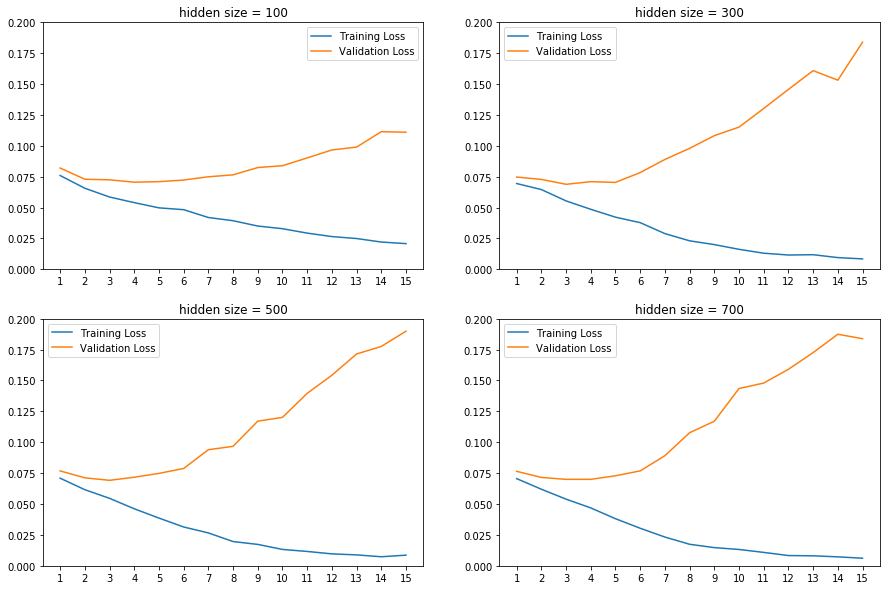

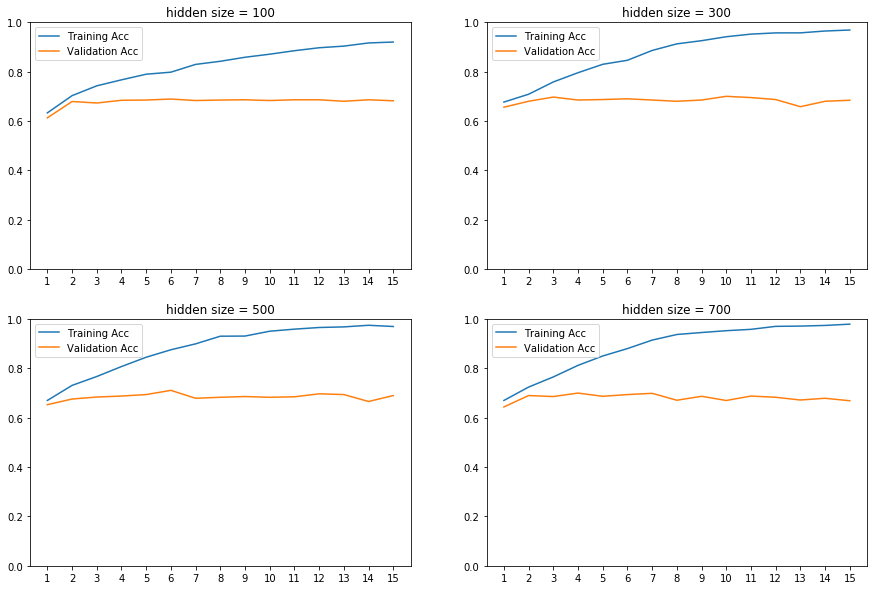

In [41]:
plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.plot(range(1, len(loss_train_t[0])+1), loss_train_t[0], label="Training Loss")
plt.plot(range(1, len(loss_val_t[0])+1), loss_val_t[0], label="Validation Loss")
plt.xticks(range(1, len(loss_val_t[0])+1))
plt.ylim(0, 0.2)
plt.legend()
plt.title("hidden size = 100")

plt.subplot(222)
plt.plot(range(1, len(loss_train_t[1])+1), loss_train_t[1], label="Training Loss")
plt.plot(range(1, len(loss_val_t[1])+1), loss_val_t[1], label="Validation Loss")
plt.xticks(range(1, len(loss_val_t[1])+1))
plt.ylim(0, 0.2)
plt.legend()
plt.title("hidden size = 300")

plt.subplot(223)
plt.plot(range(1, len(loss_train_t[2])+1), loss_train_t[2], label="Training Loss")
plt.plot(range(1, len(loss_val_t[2])+1), loss_val_t[2], label="Validation Loss")
plt.xticks(range(1, len(loss_val_t[2])+1))
plt.ylim(0, 0.2)
plt.legend()
plt.title("hidden size = 500")

plt.subplot(224)
plt.plot(range(1, len(loss_train_t[3])+1), loss_train_t[3], label="Training Loss")
plt.plot(range(1, len(loss_val_t[3])+1), loss_val_t[3], label="Validation Loss")
plt.xticks(range(1, len(loss_val_t[3])+1))
plt.ylim(0, 0.2)
plt.legend()
plt.title("hidden size = 700")
plt.savefig("hidden_cnn_loss.pdf")
plt.show()

plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.plot(range(1, len(acc_train_t[0])+1), acc_train_t[0], label="Training Acc")
plt.plot(range(1, len(acc_val_t[0])+1), acc_val_t[0], label="Validation Acc")
plt.xticks(range(1, len(acc_val_t[0])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("hidden size = 100")

plt.subplot(222)
plt.plot(range(1, len(acc_train_t[1])+1), acc_train_t[1], label="Training Acc")
plt.plot(range(1, len(acc_val_t[1])+1), acc_val_t[1], label="Validation Acc")
plt.xticks(range(1, len(acc_val_t[1])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("hidden size = 300")

plt.subplot(223)
plt.plot(range(1, len(acc_train_t[2])+1), acc_train_t[2], label="Training Acc")
plt.plot(range(1, len(acc_val_t[2])+1), acc_val_t[2], label="Validation Acc")
plt.xticks(range(1, len(acc_val_t[2])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("hidden size = 500")

plt.subplot(224)
plt.plot(range(1, len(acc_train_t[3])+1), acc_train_t[3], label="Training Acc")
plt.plot(range(1, len(acc_val_t[3])+1), acc_val_t[3], label="Validation Acc")
plt.xticks(range(1, len(acc_val_t[3])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("hidden size = 700")
plt.savefig("hidden_cnn_acc.pdf")
plt.show()

In [42]:
pkl.dump(loss_train_t,open("loss_train_t.p","wb"))
pkl.dump(loss_val_t,open("loss_val_t.p","wb"))
pkl.dump(acc_train_t,open("acc_train_t.p","wb"))
pkl.dump(acc_val_t,open("acc_val_t.p","wb"))

In [29]:
loss_train_t = pkl.load(open("loss_train_t.p","rb"))
loss_val_t = pkl.load(open("loss_val_t.p","rb"))
acc_train_t = pkl.load(open("acc_train_t.p","rb"))
acc_val_t = pkl.load(open("acc_val_t.p","rb"))

### kernel size

kernel size = 7
Number of parameters is 3003003
Epoch: [1/15], Train Loss: 0.07385258363127693, Val Loss: 0.08009088778495789, Val Acc: 0.6350000500679016
Epoch: [2/15], Train Loss: 0.06735701003730286, Val Loss: 0.07611766040325166, Val Acc: 0.6640000343322754
Epoch: [3/15], Train Loss: 0.05961757815957076, Val Loss: 0.07461294651031496, Val Acc: 0.6660000085830688
Epoch: [4/15], Train Loss: 0.05339387650609008, Val Loss: 0.07559620141983031, Val Acc: 0.675000011920929
Epoch: [5/15], Train Loss: 0.04488525126993655, Val Loss: 0.07714431202411652, Val Acc: 0.6650000214576721
Epoch: [6/15], Train Loss: 0.03540280834078795, Val Loss: 0.08739036083221435, Val Acc: 0.6730000376701355
Epoch: [7/15], Train Loss: 0.027638934449851587, Val Loss: 0.10136597192287446, Val Acc: 0.6440000534057617
Epoch: [8/15], Train Loss: 0.020605855917111046, Val Loss: 0.10906516242027282, Val Acc: 0.656000018119812
Epoch: [9/15], Train Loss: 0.01674147042900321, Val Loss: 0.12751970636844634, Val Acc: 0.642000

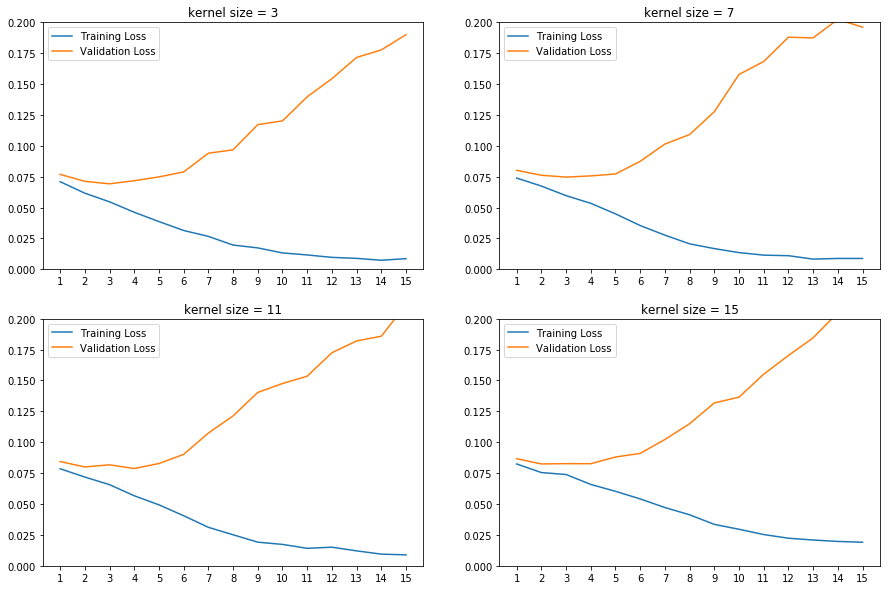

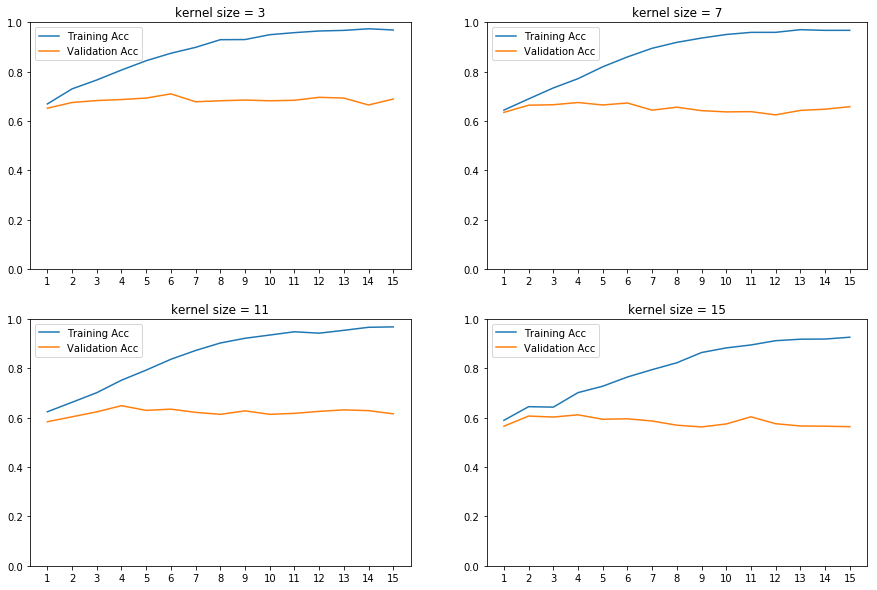

In [30]:
learning_rate = 0.001
emb_size = 300
middle_size = 200
num_epochs =15
kernel_size = 3
padding = 1
hidden_size =  500

loss_train_t = [loss_train_t[2]]
loss_val_t = [loss_val_t[2]]
acc_val_t = [acc_val_t[2]]
acc_train_t = [acc_train_t[2]]

for kernel_size in [7, 11, 15]:
    print("kernel size = {}".format(kernel_size))
    padding = int((kernel_size-1)/2)
    loss_train = []
    loss_val = []
    acc_val = []
    acc_train = []


    model = CNN(emb_size, hidden_size, middle_size, num_embeddings, kernel_size, padding).to(device)
    criterion = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    print("Number of parameters is {}".format(get_n_params(model)))
    for epoch in range(num_epochs):
    #scheduler.step()
        loss = do_train(
            model=model, 
            criterion=criterion,
            dataloader=train_loader,
            optimizer=optimizer,
        )
        val_loss, val_acc = acc(model, val_loader)
        train_loss, train_acc = acc(model,train_loader)
        loss_val.append(val_loss)
        acc_val.append(val_acc)
        loss_train.append(train_loss)
        acc_train.append(train_acc)
        print('Epoch: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format( 
                           epoch+1, num_epochs, train_loss, val_loss, val_acc))
        
    loss_train_t.append(loss_train)
    loss_val_t.append(loss_val)
    acc_val_t.append(acc_val)
    acc_train_t.append(acc_train)


plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.plot(range(1, len(loss_train_t[0])+1), loss_train_t[0], label="Training Loss")
plt.plot(range(1, len(loss_val_t[0])+1), loss_val_t[0], label="Validation Loss")
plt.xticks(range(1, len(loss_val_t[0])+1))
plt.ylim(0, 0.2)
plt.legend()
plt.title("kernel size = 3")

plt.subplot(222)
plt.plot(range(1, len(loss_train_t[1])+1), loss_train_t[1], label="Training Loss")
plt.plot(range(1, len(loss_val_t[1])+1), loss_val_t[1], label="Validation Loss")
plt.xticks(range(1, len(loss_val_t[1])+1))
plt.ylim(0, 0.2)
plt.legend()
plt.title("kernel size = 7")

plt.subplot(223)
plt.plot(range(1, len(loss_train_t[2])+1), loss_train_t[2], label="Training Loss")
plt.plot(range(1, len(loss_val_t[2])+1), loss_val_t[2], label="Validation Loss")
plt.xticks(range(1, len(loss_val_t[2])+1))
plt.ylim(0, 0.2)
plt.legend()
plt.title("kernel size = 11")

plt.subplot(224)
plt.plot(range(1, len(loss_train_t[3])+1), loss_train_t[3], label="Training Loss")
plt.plot(range(1, len(loss_val_t[3])+1), loss_val_t[3], label="Validation Loss")
plt.xticks(range(1, len(loss_val_t[3])+1))
plt.ylim(0, 0.2)
plt.legend()
plt.title("kernel size = 15")
plt.savefig("kernel_cnn_loss.pdf")
plt.show()

plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.plot(range(1, len(acc_train_t[0])+1), acc_train_t[0], label="Training Acc")
plt.plot(range(1, len(acc_val_t[0])+1), acc_val_t[0], label="Validation Acc")
plt.xticks(range(1, len(acc_val_t[0])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("kernel size = 3")

plt.subplot(222)
plt.plot(range(1, len(acc_train_t[1])+1), acc_train_t[1], label="Training Acc")
plt.plot(range(1, len(acc_val_t[1])+1), acc_val_t[1], label="Validation Acc")
plt.xticks(range(1, len(acc_val_t[1])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("kernel size = 7")

plt.subplot(223)
plt.plot(range(1, len(acc_train_t[2])+1), acc_train_t[2], label="Training Acc")
plt.plot(range(1, len(acc_val_t[2])+1), acc_val_t[2], label="Validation Acc")
plt.xticks(range(1, len(acc_val_t[2])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("kernel size = 11")

plt.subplot(224)
plt.plot(range(1, len(acc_train_t[3])+1), acc_train_t[3], label="Training Acc")
plt.plot(range(1, len(acc_val_t[3])+1), acc_val_t[3], label="Validation Acc")
plt.xticks(range(1, len(acc_val_t[3])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("kernel size = 15")
plt.savefig("kernel_cnn_acc.pdf")
plt.show()

### ways of interaction

In [32]:
class CNN_max(nn.Module):
    def __init__(self, emb_size, hidden_size, middle_size,  num_embeddings, kernel_size, padding):

        super(CNN_max, self).__init__()

        self.hidden_size = hidden_size
        self.embed = nn.Embedding(num_embeddings, emb_size, padding_idx=PAD_IDX)
    
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size=kernel_size, padding=padding)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size, padding=padding)

        self.linear1 = nn.Linear(hidden_size , middle_size)
        self.linear2 = nn.Linear(middle_size, 3)
        
        self.init_weights()

    def init_weights(self):
        loaded_embeddings[:2, :] = np.random.randn(2,300)
        self.embed.weight = nn.Parameter(torch.from_numpy(loaded_embeddings).float())
        return
    
    def forward(self, x):
        
        out1 = self.embed(x['s1'])
        out2 = self.embed(x['s2'])
        batch_size, seq_len = x['s1'].size()

        out1 = self.conv1(out1.transpose(1, 2)).transpose(1, 2)
        out2 = self.conv1(out2.transpose(1, 2)).transpose(1, 2)
        
        out1 = F.relu(out1.contiguous().view(-1, out1.size(-1))).view(batch_size, seq_len, out1.size(-1))
        out2 = F.relu(out2.contiguous().view(-1, out2.size(-1))).view(batch_size, seq_len, out2.size(-1))
        

        out1 = self.conv2(out1.transpose(1, 2)).transpose(1, 2)
        out2 = self.conv2(out2.transpose(1, 2)).transpose(1, 2)
        
        out1 = F.relu(out1.contiguous().view(-1, out1.size(-1))).view(batch_size, seq_len, out1.size(-1))
        out2 = F.relu(out2.contiguous().view(-1, out2.size(-1))).view(batch_size, seq_len, out2.size(-1))
        
        out1 = torch.max(out1, dim=1)[0]
        out2 = torch.max(out2, dim=1)[0]
        
        tmp = torch.zeros(out2.size()).to(device)
        for i in range(batch_size):
            tmp[x['s2_order'][i],:] = out2[i]
        out2 = tmp[list(x['s1_order']),:]
        
        out = torch.max(out1, out2)
        
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.log_softmax(out, dim=1)
        return out

learning_rate = 0.001
emb_size = 300
middle_size = 200
num_epochs =15
kernel_size = 3
padding = 1
hidden_size = 500

loss_train_t = [loss_train_t[0]]
loss_val_t = [loss_val_t[0]]
acc_val_t = [acc_val_t[0]]
acc_train_t = [acc_train_t[0]]


print("maxpooling")

loss_train = []
loss_val = []
acc_val = []
acc_train = []


model = CNN_max(emb_size, hidden_size, middle_size, num_embeddings, kernel_size, padding).to(device)
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print("Number of parameters is {}".format(get_n_params(model)))
for epoch in range(num_epochs):
#scheduler.step()
    loss = do_train(
        model=model, 
        criterion=criterion,
        dataloader=train_loader,
        optimizer=optimizer,
    )
    val_loss, val_acc = acc(model, val_loader)
    train_loss, train_acc = acc(model,train_loader)
    loss_val.append(val_loss)
    acc_val.append(val_acc)
    loss_train.append(train_loss)
    acc_train.append(train_acc)
    print('Epoch: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format( 
                           epoch+1, num_epochs, train_loss, val_loss, val_acc))
        
loss_train_t.append(loss_train)
loss_val_t.append(loss_val)
acc_val_t.append(acc_val)
acc_train_t.append(acc_train)

maxpooling
Number of parameters is 1303003
Epoch: [1/15], Train Loss: 0.07968757784485805, Val Loss: 0.08473195695877074, Val Acc: 0.5879999995231628
Epoch: [2/15], Train Loss: 0.07104817151427267, Val Loss: 0.07990069699287415, Val Acc: 0.5950000286102295
Epoch: [3/15], Train Loss: 0.06312263136684888, Val Loss: 0.07877965700626374, Val Acc: 0.625
Epoch: [4/15], Train Loss: 0.05532769292771823, Val Loss: 0.07860576045513151, Val Acc: 0.64000004529953
Epoch: [5/15], Train Loss: 0.0457244477516413, Val Loss: 0.08100572741031645, Val Acc: 0.6650000214576721
Epoch: [6/15], Train Loss: 0.04155504808276895, Val Loss: 0.08830159342288971, Val Acc: 0.625
Epoch: [7/15], Train Loss: 0.030951195671260333, Val Loss: 0.09375377440452576, Val Acc: 0.6190000176429749
Epoch: [8/15], Train Loss: 0.026564571855068185, Val Loss: 0.11128628468513489, Val Acc: 0.6010000109672546
Epoch: [9/15], Train Loss: 0.02024744663000108, Val Loss: 0.1199955664873123, Val Acc: 0.6100000143051147
Epoch: [10/15], Train 

In [33]:
class CNN_pair_mul(nn.Module):
    def __init__(self, emb_size, hidden_size, middle_size,  num_embeddings, kernel_size, padding):

        super(CNN_pair_mul, self).__init__()

        self.hidden_size = hidden_size
        self.embed = nn.Embedding(num_embeddings, emb_size, padding_idx=PAD_IDX)
    
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size=kernel_size, padding=padding)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size, padding=padding)

        self.linear1 = nn.Linear(hidden_size , middle_size)
        self.linear2 = nn.Linear(middle_size, 3)
        
        self.init_weights()

    def init_weights(self):
        loaded_embeddings[:2, :] = np.random.randn(2,300)
        self.embed.weight = nn.Parameter(torch.from_numpy(loaded_embeddings).float())
        return
    
    def forward(self, x):
        
        out1 = self.embed(x['s1'])
        out2 = self.embed(x['s2'])
        batch_size, seq_len = x['s1'].size()

        out1 = self.conv1(out1.transpose(1, 2)).transpose(1, 2)
        out2 = self.conv1(out2.transpose(1, 2)).transpose(1, 2)
        
        out1 = F.relu(out1.contiguous().view(-1, out1.size(-1))).view(batch_size, seq_len, out1.size(-1))
        out2 = F.relu(out2.contiguous().view(-1, out2.size(-1))).view(batch_size, seq_len, out2.size(-1))
        

        out1 = self.conv2(out1.transpose(1, 2)).transpose(1, 2)
        out2 = self.conv2(out2.transpose(1, 2)).transpose(1, 2)
        
        out1 = F.relu(out1.contiguous().view(-1, out1.size(-1))).view(batch_size, seq_len, out1.size(-1))
        out2 = F.relu(out2.contiguous().view(-1, out2.size(-1))).view(batch_size, seq_len, out2.size(-1))
        
        out1 = torch.max(out1, dim=1)[0]
        out2 = torch.max(out2, dim=1)[0]
        
        tmp = torch.zeros(out2.size()).to(device)
        for i in range(batch_size):
            tmp[x['s2_order'][i],:] = out2[i]
        out2 = tmp[list(x['s1_order']),:]
        
        out = out1 * out2
        
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.log_softmax(out, dim=1)
        return out

learning_rate = 0.001
emb_size = 300
middle_size = 200
num_epochs =15
kernel_size = 3
padding = 1
hidden_size = 500


print("pairwise multiplication")

loss_train = []
loss_val = []
acc_val = []
acc_train = []


model = CNN_pair_mul(emb_size, hidden_size, middle_size, num_embeddings, kernel_size, padding).to(device)
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print("Number of parameters is {}".format(get_n_params(model)))
for epoch in range(num_epochs):
#scheduler.step()
    loss = do_train(
        model=model, 
        criterion=criterion,
        dataloader=train_loader,
        optimizer=optimizer,
    )
    val_loss, val_acc = acc(model, val_loader)
    train_loss, train_acc = acc(model,train_loader)
    loss_val.append(val_loss)
    acc_val.append(val_acc)
    loss_train.append(train_loss)
    acc_train.append(train_acc)
    print('Epoch: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format( 
                           epoch+1, num_epochs, train_loss, val_loss, val_acc))
        
loss_train_t.append(loss_train)
loss_val_t.append(loss_val)
acc_val_t.append(acc_val)
acc_train_t.append(acc_train)

pairwise multiplication
Number of parameters is 1303003
Epoch: [1/15], Train Loss: 0.07630525628328336, Val Loss: 0.08178882086277008, Val Acc: 0.6160000562667847
Epoch: [2/15], Train Loss: 0.06972074741721158, Val Loss: 0.07952351367473602, Val Acc: 0.6320000290870667
Epoch: [3/15], Train Loss: 0.058919166664481167, Val Loss: 0.07486931455135346, Val Acc: 0.6480000019073486
Epoch: [4/15], Train Loss: 0.05073999048471454, Val Loss: 0.07525487530231476, Val Acc: 0.6550000309944153
Epoch: [5/15], Train Loss: 0.04333965678334234, Val Loss: 0.07719567525386813, Val Acc: 0.6540000438690186
Epoch: [6/15], Train Loss: 0.035411061463952107, Val Loss: 0.08028779447078704, Val Acc: 0.6800000071525574
Epoch: [7/15], Train Loss: 0.02793244558542971, Val Loss: 0.0907002478837967, Val Acc: 0.6600000262260437
Epoch: [8/15], Train Loss: 0.021977544706463827, Val Loss: 0.09713794434070587, Val Acc: 0.6640000343322754
Epoch: [9/15], Train Loss: 0.017750660228133208, Val Loss: 0.11194063889980316, Val Ac

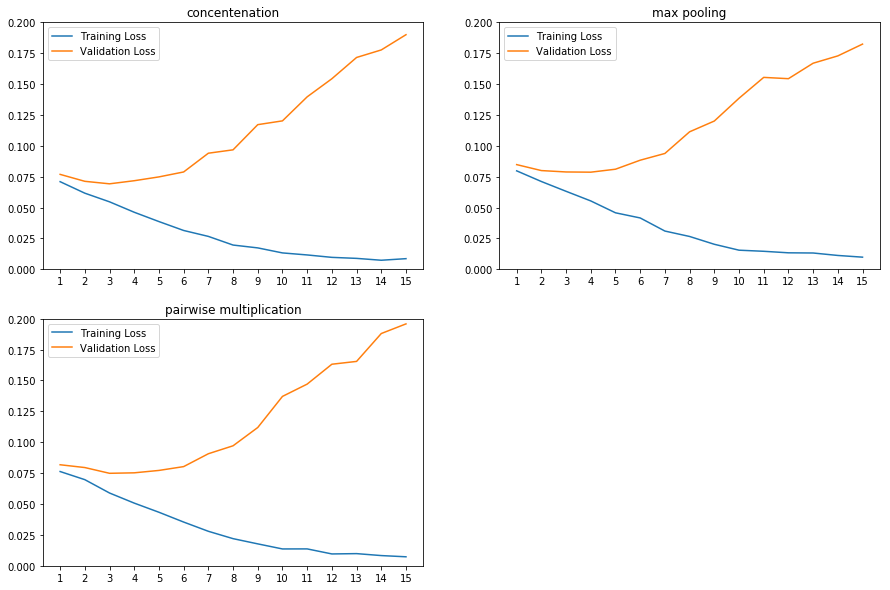

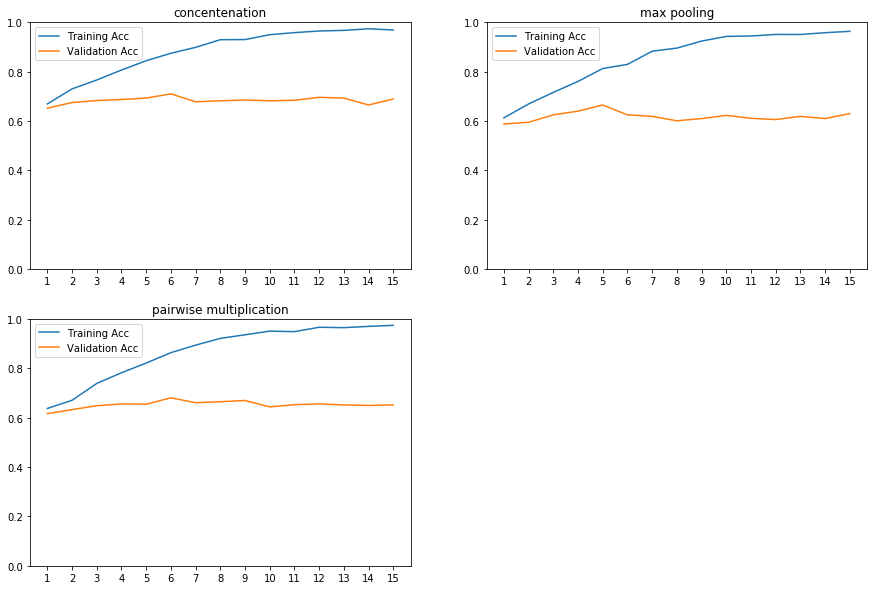

In [34]:
plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.plot(range(1, len(loss_train_t[0])+1), loss_train_t[0], label="Training Loss")
plt.plot(range(1, len(loss_val_t[0])+1), loss_val_t[0], label="Validation Loss")
plt.xticks(range(1, len(loss_val_t[0])+1))
plt.ylim(0, 0.2)
plt.legend()
plt.title("concentenation")

plt.subplot(222)
plt.plot(range(1, len(loss_train_t[1])+1), loss_train_t[1], label="Training Loss")
plt.plot(range(1, len(loss_val_t[1])+1), loss_val_t[1], label="Validation Loss")
plt.xticks(range(1, len(loss_val_t[1])+1))
plt.ylim(0, 0.2)
plt.legend()
plt.title("max pooling")

plt.subplot(223)
plt.plot(range(1, len(loss_train_t[2])+1), loss_train_t[2], label="Training Loss")
plt.plot(range(1, len(loss_val_t[2])+1), loss_val_t[2], label="Validation Loss")
plt.xticks(range(1, len(loss_val_t[2])+1))
plt.ylim(0, 0.2)
plt.legend()
plt.title("pairwise multiplication")

plt.savefig("interacting_cnn_loss.pdf")
plt.show()

plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.plot(range(1, len(acc_train_t[0])+1), acc_train_t[0], label="Training Acc")
plt.plot(range(1, len(acc_val_t[0])+1), acc_val_t[0], label="Validation Acc")
plt.xticks(range(1, len(acc_val_t[0])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("concentenation")

plt.subplot(222)
plt.plot(range(1, len(acc_train_t[1])+1), acc_train_t[1], label="Training Acc")
plt.plot(range(1, len(acc_val_t[1])+1), acc_val_t[1], label="Validation Acc")
plt.xticks(range(1, len(acc_val_t[1])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("max pooling")

plt.subplot(223)
plt.plot(range(1, len(acc_train_t[2])+1), acc_train_t[2], label="Training Acc")
plt.plot(range(1, len(acc_val_t[2])+1), acc_val_t[2], label="Validation Acc")
plt.xticks(range(1, len(acc_val_t[2])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("pairwise multiplication")

plt.savefig("interacting_cnn_acc.pdf")
plt.show()

### Regularization

In [35]:
learning_rate = 0.001
emb_size = 300
middle_size = 200
num_epochs =15
hidden_size = 500
kernel_size
padding

loss_train_t = [loss_train_t[0]]
loss_val_t = [loss_val_t[0]]
acc_val_t = [acc_val_t[0]]
acc_train_t = [acc_train_t[0]]


print("weight decay")

loss_train = []
loss_val = []
acc_val = []
acc_train = []


model = CNN(emb_size, hidden_size, middle_size, num_embeddings, kernel_size, padding).to(device)
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
print("Number of parameters is {}".format(get_n_params(model)))
for epoch in range(num_epochs):
#scheduler.step()
    loss = do_train(
        model=model, 
        criterion=criterion,
        dataloader=train_loader,
        optimizer=optimizer,
    )
    val_loss, val_acc = acc(model, val_loader)
    train_loss, train_acc = acc(model,train_loader)
    loss_val.append(val_loss)
    acc_val.append(val_acc)
    loss_train.append(train_loss)
    acc_train.append(train_acc)
    print('Epoch: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format( 
                           epoch+1, num_epochs, train_loss, val_loss, val_acc))
        
loss_train_t.append(loss_train)
loss_val_t.append(loss_val)
acc_val_t.append(acc_val)
acc_train_t.append(acc_train)

weight decay
Number of parameters is 1403003
Epoch: [1/15], Train Loss: 0.0701625095164776, Val Loss: 0.07656609785556794, Val Acc: 0.6480000019073486
Epoch: [2/15], Train Loss: 0.06690918309152119, Val Loss: 0.07543134677410125, Val Acc: 0.6450000405311584
Epoch: [3/15], Train Loss: 0.06417728657484062, Val Loss: 0.07413782823085786, Val Acc: 0.6640000343322754
Epoch: [4/15], Train Loss: 0.07090745321273789, Val Loss: 0.0785504057407379, Val Acc: 0.6410000324249268
Epoch: [5/15], Train Loss: 0.07863657631158825, Val Loss: 0.08396707034111026, Val Acc: 0.6020000576972961
Epoch: [6/15], Train Loss: 0.08349890055656443, Val Loss: 0.08777298867702484, Val Acc: 0.578000009059906
Epoch: [7/15], Train Loss: 0.09222958699464806, Val Loss: 0.09559248948097228, Val Acc: 0.5090000033378601
Epoch: [8/15], Train Loss: 0.09940315355300908, Val Loss: 0.10242962837219237, Val Acc: 0.43800002336502075
Epoch: [9/15], Train Loss: 0.10258317634820938, Val Loss: 0.10497864389419553, Val Acc: 0.35200002789

In [38]:
class CNN_dropout(nn.Module):
    def __init__(self, emb_size, hidden_size, middle_size,  num_embeddings, kernel_size, padding):

        super(CNN_dropout, self).__init__()

        self.hidden_size = hidden_size
        self.embed = nn.Embedding(num_embeddings, emb_size, padding_idx=PAD_IDX)
    
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size=kernel_size, padding=padding)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size, padding=padding)

        self.linear1 = nn.Linear(hidden_size*2 , middle_size)
        self.linear2 = nn.Linear(middle_size, 3)
        
        self.dropout = nn.Dropout(p=0.5)
        
        self.init_weights()

    def init_weights(self):
        loaded_embeddings[:2, :] = np.random.randn(2,300)
        self.embed.weight = nn.Parameter(torch.from_numpy(loaded_embeddings).float())
        return
    
    def forward(self, x):
        
        out1 = self.embed(x['s1'])
        out2 = self.embed(x['s2'])
        batch_size, seq_len = x['s1'].size()

        out1 = self.conv1(out1.transpose(1, 2)).transpose(1, 2)
        out2 = self.conv1(out2.transpose(1, 2)).transpose(1, 2)
        
        out1 = F.relu(out1.contiguous().view(-1, out1.size(-1))).view(batch_size, seq_len, out1.size(-1))
        out2 = F.relu(out2.contiguous().view(-1, out2.size(-1))).view(batch_size, seq_len, out2.size(-1))
        

        out1 = self.conv2(out1.transpose(1, 2)).transpose(1, 2)
        out2 = self.conv2(out2.transpose(1, 2)).transpose(1, 2)
        
        out1 = F.relu(out1.contiguous().view(-1, out1.size(-1))).view(batch_size, seq_len, out1.size(-1))
        out2 = F.relu(out2.contiguous().view(-1, out2.size(-1))).view(batch_size, seq_len, out2.size(-1))
        
        out1 = torch.max(out1, dim=1)[0]
        out2 = torch.max(out2, dim=1)[0]
        
        tmp = torch.zeros(out2.size()).to(device)
        for i in range(batch_size):
            tmp[x['s2_order'][i],:] = out2[i]
        out2 = tmp[list(x['s1_order']),:]
        
        out = torch.cat([out1, out2], dim=1)
        
        out = self.linear1(out)
        out = F.relu(out)
        out = self.dropout(out)
        out = self.linear2(out)
        out = F.log_softmax(out, dim=1)
        return out

learning_rate = 0.001
emb_size = 300
middle_size = 200
num_epochs =15
kernel_size = 3
padding = 1
hidden_size = 500

print("dropout")

loss_train = []
loss_val = []
acc_val = []
acc_train = []


model = CNN_dropout(emb_size, hidden_size, middle_size, num_embeddings, kernel_size, padding).to(device)
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print("Number of parameters is {}".format(get_n_params(model)))
for epoch in range(num_epochs):
#scheduler.step()
    loss = do_train(
        model=model, 
        criterion=criterion,
        dataloader=train_loader,
        optimizer=optimizer,
    )
    val_loss, val_acc = acc(model, val_loader)
    train_loss, train_acc = acc(model,train_loader)
    loss_val.append(val_loss)
    acc_val.append(val_acc)
    loss_train.append(train_loss)
    acc_train.append(train_acc)
    print('Epoch: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format( 
                           epoch+1, num_epochs, train_loss, val_loss, val_acc))
        
loss_train_t.append(loss_train)
loss_val_t.append(loss_val)
acc_val_t.append(acc_val)
acc_train_t.append(acc_train)

dropout
Number of parameters is 1403003
Epoch: [1/15], Train Loss: 0.07143137708902357, Val Loss: 0.07739225220680236, Val Acc: 0.6330000162124634
Epoch: [2/15], Train Loss: 0.06502643453121182, Val Loss: 0.0731485072374344, Val Acc: 0.6650000214576721
Epoch: [3/15], Train Loss: 0.05940397448658942, Val Loss: 0.07191156113147736, Val Acc: 0.6580000519752502
Epoch: [4/15], Train Loss: 0.05337506299495703, Val Loss: 0.07167987942695618, Val Acc: 0.6800000071525574
Epoch: [5/15], Train Loss: 0.04700710798501962, Val Loss: 0.07388981080055236, Val Acc: 0.6820000410079956
Epoch: [6/15], Train Loss: 0.04159762115299697, Val Loss: 0.07671514499187469, Val Acc: 0.6800000071525574
Epoch: [7/15], Train Loss: 0.03652636080533269, Val Loss: 0.08312566316127776, Val Acc: 0.6800000071525574
Epoch: [8/15], Train Loss: 0.03086560328006738, Val Loss: 0.0940733674764633, Val Acc: 0.6790000200271606
Epoch: [9/15], Train Loss: 0.028367255428433394, Val Loss: 0.09996568608283996, Val Acc: 0.669000029563903

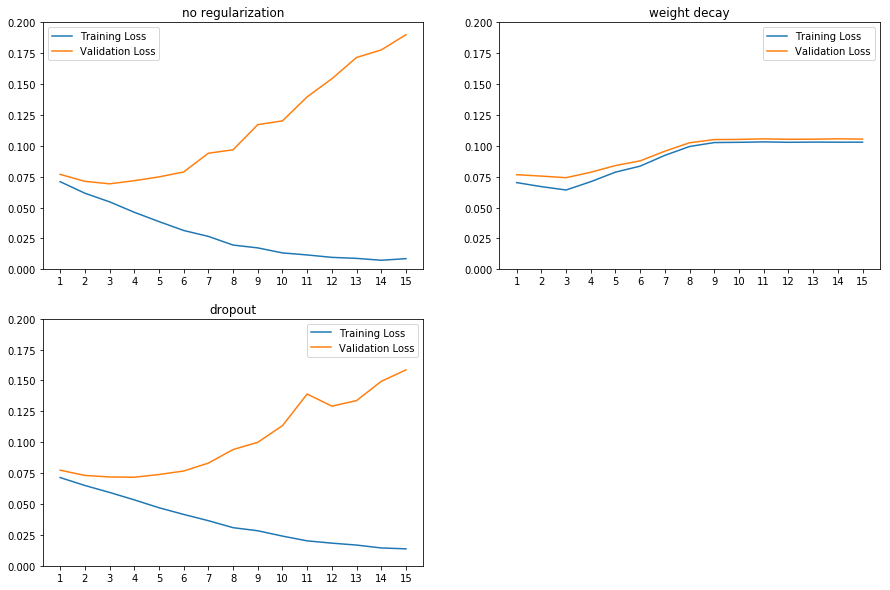

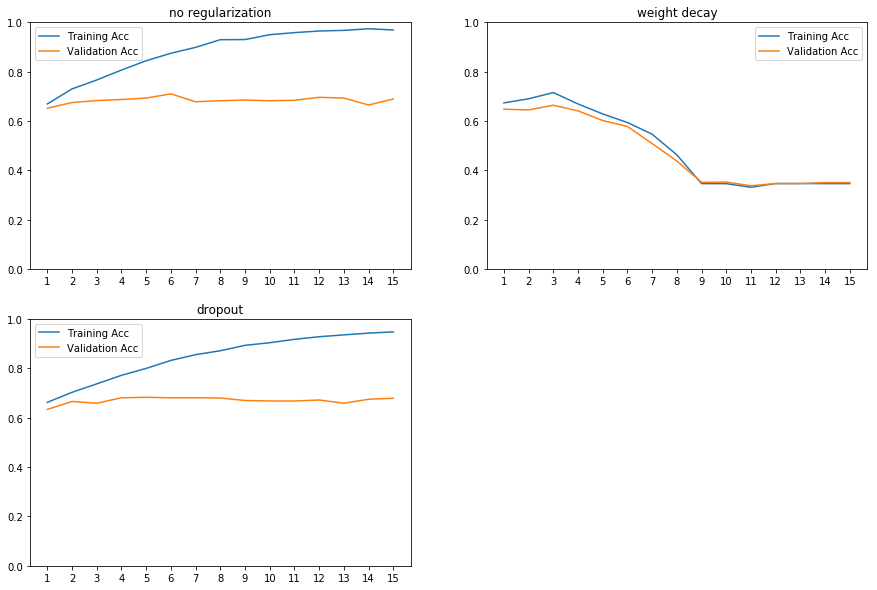

In [39]:
plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.plot(range(1, len(loss_train_t[0])+1), loss_train_t[0], label="Training Loss")
plt.plot(range(1, len(loss_val_t[0])+1), loss_val_t[0], label="Validation Loss")
plt.xticks(range(1, len(loss_val_t[0])+1))
plt.ylim(0, 0.2)
plt.legend()
plt.title("no regularization")

plt.subplot(222)
plt.plot(range(1, len(loss_train_t[1])+1), loss_train_t[1], label="Training Loss")
plt.plot(range(1, len(loss_val_t[1])+1), loss_val_t[1], label="Validation Loss")
plt.xticks(range(1, len(loss_val_t[1])+1))
plt.ylim(0, 0.2)
plt.legend()
plt.title("weight decay")

plt.subplot(223)
plt.plot(range(1, len(loss_train_t[2])+1), loss_train_t[2], label="Training Loss")
plt.plot(range(1, len(loss_val_t[2])+1), loss_val_t[2], label="Validation Loss")
plt.xticks(range(1, len(loss_val_t[2])+1))
plt.ylim(0, 0.2)
plt.legend()
plt.title("dropout")
plt.savefig("regularization_cnn_loss.pdf")
plt.show()

plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.plot(range(1, len(acc_train_t[0])+1), acc_train_t[0], label="Training Acc")
plt.plot(range(1, len(acc_val_t[0])+1), acc_val_t[0], label="Validation Acc")
plt.xticks(range(1, len(acc_val_t[0])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("no regularization")

plt.subplot(222)
plt.plot(range(1, len(acc_train_t[1])+1), acc_train_t[1], label="Training Acc")
plt.plot(range(1, len(acc_val_t[1])+1), acc_val_t[1], label="Validation Acc")
plt.xticks(range(1, len(acc_val_t[1])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("weight decay")

plt.subplot(223)
plt.plot(range(1, len(acc_train_t[2])+1), acc_train_t[2], label="Training Acc")
plt.plot(range(1, len(acc_val_t[2])+1), acc_val_t[2], label="Validation Acc")
plt.xticks(range(1, len(acc_val_t[2])+1))
plt.ylim(0, 1)
plt.legend()
plt.title("dropout")

plt.savefig("regularization_acc_cnn.pdf")
plt.show()

### correct/incorrect cases

In [29]:
learning_rate = 0.001
emb_size = 300
middle_size = 200
num_epochs =15
kernel_size = 3
padding = 1
hidden_size = 500
num_epochs = 6
model = CNN(emb_size, hidden_size, middle_size, num_embeddings, kernel_size, padding).to(device)
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    _ = do_train(
        model=model, 
        criterion=criterion,
        dataloader=train_loader,
        optimizer=optimizer,
    )

In [76]:
learning_rate = 0.001
emb_size = 300
middle_size = 200
num_epochs =15
kernel_size = 3
padding = 1
hidden_size = 500
num_epochs = 6
model = CNN(emb_size, hidden_size, middle_size, num_embeddings, kernel_size, padding).to(device)
model.load_state_dict(torch.load("cnn_state.pkl",map_location='cpu'))
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
_, pred,true = do_eval(
    model = model,
    dataloader = test_loader,
    )

In [78]:
tmp = (torch.exp(pred).max(1)[1] == true).numpy()
for i in [0, 5, 21]:
    print(val.loc[i, "sentence1"])
    print(val.loc[i, "sentence2"])
    print(val.loc[i, "label"])
    print("predicted value:{}".format(torch.exp(pred).max(1)[1][i].numpy()))

Three women on a stage , one wearing red shoes , black pants , and a gray shirt is sitting on a prop , another is sitting on the floor , and the third wearing a black shirt and pants is standing , as a gentleman in the back tunes an instrument .
There are two women standing on the stage
contradiction
predicted value:1
Two people are in a green forest .
The forest is not dead .
entailment
predicted value:2
A group of people are sitting under umbrellas on the beach .
It is a saturday
neutral
predicted value:2


In [80]:
for i in [22, 24, 25]:
    print(val.loc[i, "sentence1"])
    print(val.loc[i, "sentence2"])
    print(val.loc[i, "label"])
    print("predicted value:{}".format(torch.exp(pred).max(1)[1][i].numpy()))

A boy riding on a carnival ride turns around for a photograph .
A human riding
entailment
predicted value:1
A live band on a lawn jamming out .
A band is practicing new tunes in the garage .
contradiction
predicted value:2
man grilling fish on barbecue
The man likes to eat fish .
neutral
predicted value:0


In [30]:
torch.save(model.state_dict(), "cnn_state.pkl")

### multiNLI data

In [31]:
mnli_val_acc = {}
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
for gen in genre:
    s1_mnli_val = mnli_val.loc[mnli_val['genre']==gen,'sentence1'].values
    s2_mnli_val = mnli_val.loc[mnli_val['genre']==gen,'sentence2'].values
    label_mnli_val = mnli_val.loc[mnli_val['genre']==gen,'label'].values
    label_mnli_val = list(map(one_hot_label, label_mnli_val))
    s1_mnli_val = [i.split() for i in s1_mnli_val]
    s2_mnli_val  = [i.split() for i in s2_mnli_val]
    s1_mnli_val = list(map(word_emb, s1_mnli_val))
    s2_mnli_val  = list(map(word_emb, s2_mnli_val))
    x_mnli_val = {"s1": s1_mnli_val,
                  "s2": s2_mnli_val}
    mnli_val_dataset = MyDataset(x_mnli_val, label_mnli_val)
     
    BATCH_SIZE = 64
 
    mnli_val_loader = torch.utils.data.DataLoader(dataset=mnli_val_dataset,
                                batch_size=BATCH_SIZE,
                                collate_fn=vocab_collate_func,
                                shuffle=False)
    _, mnli_val_acc_value = acc(model,mnli_val_loader)
    mnli_val_acc[gen] = mnli_val_acc_value
mnli_val_acc

{'fiction': 0.4371859133243561,
 'government': 0.41535434126853943,
 'slate': 0.42315369844436646,
 'telephone': 0.4656716585159302,
 'travel': 0.4389002323150635}

### fine tuning

In [26]:
for gen in genre:
    print(gen)
    s1_mnli_val = mnli_val.loc[mnli_val['genre']==gen,'sentence1'].values
    s2_mnli_val = mnli_val.loc[mnli_val['genre']==gen,'sentence2'].values
    label_mnli_val = mnli_val.loc[mnli_val['genre']==gen,'label'].values
    label_mnli_val = list(map(one_hot_label, label_mnli_val))
    s1_mnli_val = [i.split() for i in s1_mnli_val]
    s2_mnli_val  = [i.split() for i in s2_mnli_val]
    s1_mnli_val = list(map(word_emb, s1_mnli_val))
    s2_mnli_val  = list(map(word_emb, s2_mnli_val))
    x_mnli_val = {"s1": s1_mnli_val,
                  "s2": s2_mnli_val}
    mnli_val_dataset = MyDataset(x_mnli_val, label_mnli_val)
    
    s1_mnli_train = mnli_train.loc[mnli_train['genre']==gen,'sentence1'].values
    s2_mnli_train = mnli_train.loc[mnli_train['genre']==gen,'sentence2'].values
    label_mnli_train = mnli_train.loc[mnli_train['genre']==gen,'label'].values
    label_mnli_train = list(map(one_hot_label, label_mnli_train))
    s1_mnli_train = [i.split() for i in s1_mnli_train]
    s2_mnli_train  = [i.split() for i in s2_mnli_train]
    s1_mnli_train = list(map(word_emb, s1_mnli_train))
    s2_mnli_train  = list(map(word_emb, s2_mnli_train))
    x_mnli_train = {"s1": s1_mnli_train,
                  "s2": s2_mnli_train}
    mnli_train_dataset = MyDataset(x_mnli_train, label_mnli_train)
    
    BATCH_SIZE = 64
    mnli_val_loader = torch.utils.data.DataLoader(dataset=mnli_val_dataset,
                                batch_size=BATCH_SIZE,
                                collate_fn=vocab_collate_func,
                                shuffle=False)
    mnli_train_loader = torch.utils.data.DataLoader(dataset=mnli_train_dataset,
                                batch_size=BATCH_SIZE,
                                collate_fn=vocab_collate_func,
                                shuffle=False)
    
    learning_rate = 0.0001
    emb_size = 300
    middle_size = 200
    num_epochs =10
    kernel_size = 3
    padding = 1
    hidden_size = 500
    
    loss_train = []
    loss_val = []
    acc_val = []
    acc_train = []


    model = CNN(emb_size, hidden_size, middle_size, num_embeddings, kernel_size, padding).to(device)
    model.load_state_dict(torch.load("cnn_state.pkl"))
    criterion = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    #print("Number of parameters is {}".format(get_n_params(model)))
    for epoch in range(num_epochs):
    #scheduler.step()
        loss = do_train(
             model=model, 
             criterion=criterion,
             dataloader=mnli_train_loader,
             optimizer=optimizer,
        )
        val_loss, val_acc = acc(model, mnli_val_loader)
        train_loss, train_acc = acc(model,mnli_train_loader)
        loss_val.append(val_loss)
        acc_val.append(val_acc)
        loss_train.append(train_loss)
        acc_train.append(train_acc)
        print('Epoch: [{}/{}], Train Loss: {}, Val Loss: {}, Val Acc: {}'.format( 
                           epoch+1, num_epochs, train_loss, val_loss, val_acc))
        

fiction
Epoch: [1/10], Train Loss: 0.10031404743229387, Val Loss: 0.10716564247955629, Val Acc: 0.4673366844654083
Epoch: [2/10], Train Loss: 0.09371143016999157, Val Loss: 0.10342445026090995, Val Acc: 0.4663316607475281
Epoch: [3/10], Train Loss: 0.0901494891352649, Val Loss: 0.10242803683832062, Val Acc: 0.4693467319011688
Epoch: [4/10], Train Loss: 0.08725579208825501, Val Loss: 0.10209735973396494, Val Acc: 0.4753768742084503
Epoch: [5/10], Train Loss: 0.08454532748839902, Val Loss: 0.10204744350970092, Val Acc: 0.4814070165157318
Epoch: [6/10], Train Loss: 0.08188224680978141, Val Loss: 0.10205890629159746, Val Acc: 0.4854271411895752
Epoch: [7/10], Train Loss: 0.07927547247616167, Val Loss: 0.10226947542410997, Val Acc: 0.48844221234321594
Epoch: [8/10], Train Loss: 0.07664564177316222, Val Loss: 0.10257823551120471, Val Acc: 0.49045225977897644
Epoch: [9/10], Train Loss: 0.07391866420058688, Val Loss: 0.10316179721199688, Val Acc: 0.49045225977897644
Epoch: [10/10], Train Loss:

In [28]:
for gen in genre:
    print("train genre: {}".format(gen))
    s1_mnli_val = mnli_val.loc[mnli_val['genre']==gen,'sentence1'].values
    s2_mnli_val = mnli_val.loc[mnli_val['genre']==gen,'sentence2'].values
    label_mnli_val = mnli_val.loc[mnli_val['genre']==gen,'label'].values
    label_mnli_val = list(map(one_hot_label, label_mnli_val))
    s1_mnli_val = [i.split() for i in s1_mnli_val]
    s2_mnli_val  = [i.split() for i in s2_mnli_val]
    s1_mnli_val = list(map(word_emb, s1_mnli_val))
    s2_mnli_val  = list(map(word_emb, s2_mnli_val))
    x_mnli_val = {"s1": s1_mnli_val,
                  "s2": s2_mnli_val}
    mnli_val_dataset = MyDataset(x_mnli_val, label_mnli_val)
    
    s1_mnli_train = mnli_train.loc[mnli_train['genre']==gen,'sentence1'].values
    s2_mnli_train = mnli_train.loc[mnli_train['genre']==gen,'sentence2'].values
    label_mnli_train = mnli_train.loc[mnli_train['genre']==gen,'label'].values
    label_mnli_train = list(map(one_hot_label, label_mnli_train))
    s1_mnli_train = [i.split() for i in s1_mnli_train]
    s2_mnli_train  = [i.split() for i in s2_mnli_train]
    s1_mnli_train = list(map(word_emb, s1_mnli_train))
    s2_mnli_train  = list(map(word_emb, s2_mnli_train))
    x_mnli_train = {"s1": s1_mnli_train,
                  "s2": s2_mnli_train}
    mnli_train_dataset = MyDataset(x_mnli_train, label_mnli_train)
    
    BATCH_SIZE = 64
    mnli_val_loader = torch.utils.data.DataLoader(dataset=mnli_val_dataset,
                                batch_size=BATCH_SIZE,
                                collate_fn=vocab_collate_func,
                                shuffle=False)
    mnli_train_loader = torch.utils.data.DataLoader(dataset=mnli_train_dataset,
                                batch_size=BATCH_SIZE,
                                collate_fn=vocab_collate_func,
                                shuffle=False)
    
    learning_rate = 0.0001
    emb_size = 300
    middle_size = 200
    num_epochs =10
    kernel_size = 3
    padding = 1
    hidden_size = 500
    
    loss_train = []
    loss_val = []
    acc_val = []
    acc_train = []


    model = CNN(emb_size, hidden_size, middle_size, num_embeddings, kernel_size, padding).to(device)
    model.load_state_dict(torch.load("cnn_state.pkl"))
    criterion = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    #print("Number of parameters is {}".format(get_n_params(model)))
    for epoch in range(num_epochs):
    #scheduler.step()
        loss = do_train(
             model=model, 
             criterion=criterion,
             dataloader=mnli_train_loader,
             optimizer=optimizer,
        )
    for gen2 in genre:
        s1_mnli_val = mnli_val.loc[mnli_val['genre']==gen2,'sentence1'].values
        s2_mnli_val = mnli_val.loc[mnli_val['genre']==gen2,'sentence2'].values
        label_mnli_val = mnli_val.loc[mnli_val['genre']==gen2,'label'].values
        label_mnli_val = list(map(one_hot_label, label_mnli_val))
        s1_mnli_val = [i.split() for i in s1_mnli_val]
        s2_mnli_val  = [i.split() for i in s2_mnli_val]
        s1_mnli_val = list(map(word_emb, s1_mnli_val))
        s2_mnli_val  = list(map(word_emb, s2_mnli_val))
        x_mnli_val = {"s1": s1_mnli_val,
                      "s2": s2_mnli_val}
        mnli_val_dataset = MyDataset(x_mnli_val, label_mnli_val)
     
        BATCH_SIZE = 64
 
        mnli_val_loader = torch.utils.data.DataLoader(dataset=mnli_val_dataset,
                                batch_size=BATCH_SIZE,
                                collate_fn=vocab_collate_func,
                                shuffle=False)
        _, mnli_val_acc_value = acc(model,mnli_val_loader)
        print("test genre: {}, test accuracy: {}".format(gen2, mnli_val_acc_value))        

train genre: fiction
test genre: fiction, test accuracy: 0.4914572834968567
test genre: telephone, test accuracy: 0.5024875998497009
test genre: slate, test accuracy: 0.455089807510376
test genre: government, test accuracy: 0.4655511677265167
test genre: travel, test accuracy: 0.48981672525405884
train genre: telephone
test genre: fiction, test accuracy: 0.4994974732398987
test genre: telephone, test accuracy: 0.5114427804946899
test genre: slate, test accuracy: 0.45009979605674744
test genre: government, test accuracy: 0.45472440123558044
test genre: travel, test accuracy: 0.48778006434440613
train genre: slate
test genre: fiction, test accuracy: 0.48241204023361206
test genre: telephone, test accuracy: 0.4905472993850708
test genre: slate, test accuracy: 0.4371257424354553
test genre: government, test accuracy: 0.47539371252059937
test genre: travel, test accuracy: 0.48676174879074097
train genre: government
test genre: fiction, test accuracy: 0.4603014886379242
test genre: telephone